In [1]:
from english_words import english_words_lower_alpha_set, english_words_lower_set
import math
from collections import Counter
import pickle
import random
import matplotlib.pyplot as plt

## Starting corpus

In [2]:
corpus_name = 'five_letter_words'
five_letter_words = [ w for w in english_words_lower_alpha_set if len(w) == 5 and w.isalpha() ]
with open('../data/wordle_possible_answers.txt', 'r') as f:
    wordle_official_list = [line.strip() for line in f.readlines()]
five_letter_words += [w for w in wordle_official_list if w not in five_letter_words]
five_letter_words += ['tares']

num_words = len(five_letter_words)
num_bits_uncertainty = math.log(num_words, 2)
print('num 5 letter words:', num_words)
print('bits of info to uncover:', num_bits_uncertainty)

num 5 letter words: 3578
bits of info to uncover: 11.80493767205191


## Helper functions


### Possibilities per guess

In [3]:
def all_outcomes(element_wise_outcomes, size):
    if size == 0:
        return [[]]
    elif size == 1:
        return [[e] for e in element_wise_outcomes]
    out = []
    for e in element_wise_outcomes:
        out += [[e] + o for o in all_outcomes(element_wise_outcomes, size - 1)]
    return out


def parse_outcome(guess, outcome):
    correct, present, present_positions, not_present = [], Counter(), [], set()
    for letter, letter_outcome in zip(guess, outcome):
        if letter_outcome == 0:
            not_present.add(letter)
            correct += [None]
            present_positions += [None]
        elif letter_outcome == 1:
            present[letter] += 1 #present[letter] -= 1
            present_positions += [letter]
            correct += [None]
        elif letter_outcome == 2:
            correct += letter
            present_positions += [None]
    return correct, present, present_positions, not_present



def word_matches_present(remaining_letters, present, not_present):
    for present_letter, present_count in present.items():
        count_after_present = remaining_letters[present_letter] - present_count
        # need exact count in letter in not_present as well, else need positive count (0 incl)
        if (present_letter in not_present and count_after_present != 0) or\
           (count_after_present < 0):
            return False
        # attention update remaining letters, not returning it
        remaining_letters[present_letter] = count_after_present
    return True

# def word_matches_present(remaining_letters, present):
#     for present_letter, present_count in present.items():
#         if remaining_letters[present_letter] - present_count != 0:
#             return False
#     return True

# def word_matches_present(remaining_letters, present):
#     tally = Counter()
#     tally.update(remaining_letters)
#     tally.update(present)
#     sorted_tally = tally.most_common()
#     return sorted_tally[0][1] == sorted_tally[-1][1] == 0
# def word_matches_present(remaining_letters, present):
#     tally = Counter()
#     tally.update(remaining_letters)
#     tally.update(present)
#     return tally.most_common()[-1][1] >= 0



def word_matches_not_present(remaining_letters, not_present):
    for letter, count in remaining_letters.items():
        if letter in not_present and count > 0:
            return False
    return True

# def word_matches_not_present(remaining_letters, not_present):
#     for letter in remaining_letters.keys():
#         if letter in not_present:
#             return False
#     return True
            

def word_matches_correct_and_present_positions(word, correct, present_positions):
    remaining_letters = Counter(word)
#     print('matches_correct_and_present_positions?', word)
    for idx, (to_match, to_avoid) in enumerate(zip(correct, present_positions)):
        if to_match and to_match.isalpha():
            if word[idx] != to_match:
                return False, None
            else:
                remaining_letters[word[idx]] -= 1
        if to_avoid and to_avoid.isalpha() and word[idx] == to_avoid:
            return False, None
    return True, remaining_letters


def get_init_possibilities(corpus, correct, present_positions):
    possibilities = {}
    for word in corpus:
        matches, remaining_letters = word_matches_correct_and_present_positions(
            word, correct, present_positions)
        if matches:
            possibilities[word] = remaining_letters
    return possibilities


def get_possibilities(guess, outcome, corpus):
    correct, present, present_positions, not_present = parse_outcome(guess, outcome)
    possibilities = get_init_possibilities(corpus, correct, present_positions)
#     print('init possibilities', possibilities)
    for word in list(possibilities.keys()):
        remaining_letters = possibilities[word]
#         if not word_matches_present(remaining_letters, present) or \
        if not word_matches_present(remaining_letters, present, not_present) or \
           not word_matches_not_present(remaining_letters, not_present):
#             print('excluding', word, word_matches_present(remaining_letters, present), word_matches_not_present(remaining_letters, not_present))
            del possibilities[word]
            continue
    return list(possibilities.keys())

### Entropy

In [12]:
def calc_entropy(outcome_probabilities):
    return - sum([p * math.log(p, 2) for p in outcome_probabilities])


# todo : cache possibilities per word/outcome/corpus? possiblities will be used later to show user?
def get_entropy(word, corpus, outcomes):
    outcome_probabilities = []
    init_copus_len = len(corpus)
    corpus = set(corpus)
    for outcome in outcomes:
        possibilities = get_possibilities(word, outcome, corpus)
        if possibilities:
            outcome_probability = len(possibilities) / init_copus_len
            outcome_probabilities += [outcome_probability]
            corpus.difference_update(possibilities)
    return calc_entropy(outcome_probabilities)
# def get_entropy(word, corpus, outcomes):
#     outcome_probabilities = []
#     for outcome in outcomes:
#         possibilities = get_possibilities(word, outcome, corpus)
#         if possibilities:
#             outcome_probability = len(possibilities) / len(corpus)
#             outcome_probabilities += [outcome_probability]
#     return calc_entropy(outcome_probabilities)

#     info_gains = {}
#     for outcome in outcomes:
#         possibilities = get_possibilities(guess, outcome, corpus)
#         info_gains[set(outcome)] = calc_info_gain(before_len=len(corpus), after_len=(possibilities))

# def calc_info_gain(before_len, after_len):
#     before_uncertainty = math.log(before_len, 2)
#     after_uncertainty = math.log(after_len, 2)
#     return before_uncertainty - after_uncertainty

def get_best_guess(corpus=five_letter_words, outcomes=None, debug_log=False):
    if not outcomes:
        outcomes =  all_outcomes((0, 1, 2), 5)
    entropies = {}
    print(f'getting entropies for {len(corpus)} words')
    for idx, word in enumerate(corpus):
        entropy = get_entropy(word, corpus, outcomes)
        entropies[word] = entropy
        if debug_log:
            print(f'{idx}/{len(corpus) - 1}', word, entropy)
    best_guess = max(entropies, key=entropies.get)
    return best_guess, entropies

def load_or_calculate_entropies(init_best_guess, outcome):
    try:
        with open(f'../entropies/{corpus_name}/{init_best_guess}_{"".join([str(o) for o in outcome])}.pickle', 
                  'rb') as f:
            guess_entropies = pickle.load(f)
            best_guess = max(guess_entropies, key=guess_entropies.get)
            print('loaded entropies from file')
    except FileNotFoundError:
        print('file not found, calculating entropies')
        best_guess, guess_entropies = get_best_guess(corpus)
        with open(f'../entropies/{corpus_name}/{init_best_guess}_{"".join([str(o) for o in outcome])}.pickle', 
                  'wb') as f:
            pickle.dump(guess_entropies, f)
    return best_guess, guess_entropies

In [5]:
def graph_outcomes(word, corpus=five_letter_words, outcomes=None):
    if not outcomes:
        outcomes =  all_outcomes((0, 1, 2), 5)
    init_copus_len = len(corpus)
    corpus = set(corpus)
    outcome_probabilities = {}
    for outcome in outcomes:
        possibilities = get_possibilities(word, outcome, corpus)      
        if possibilities:
            outcome_probabilities[''.join([str(o) for o in outcome])] = len(possibilities) / init_copus_len
            corpus.difference_update(possibilities)
    sorted_probs = [p for p in reversed(sorted(outcome_probabilities.values()))]
    plt.bar([i for i in range(len(sorted_probs))], sorted_probs)
    plt.title(word)
    plt.show()
    print(sum(outcome_probabilities.values()), len(outcome_probabilities))
    

# TO DEBUG: 
# max entropy >7.92 ; DONE
# sum probs != 1 for words with repeating letters; DONE
# entropy values do not reflect outcome graphs DONE
# 

In [6]:
init_best_guess, init_entropies = get_best_guess(debug_log=True)
with open(f'../entropies/{corpus_name}/init_entropies.pickle', 'wb+') as f:
    pickle.dump(init_entropies, f)
print([(w, init_entropies[w]) for w in reversed(sorted(init_entropies, key=init_entropies.get))])
assert len([(w, init_entropies[w]) for w in init_entropies if init_entropies[w] > 7.924812503605782]) == 0

getting entropies for 3578 words
0/3577 clerk 4.760794450887152
1/3577 fugue 3.334640705521533
2/3577 minim 2.8824165082972524
3/3577 fight 3.8982924025118195
4/3577 novel 4.799488569531718
5/3577 adobe 4.903757581501692
6/3577 snafu 4.4713785325767
7/3577 deify 4.415893009881041
8/3577 vodka 3.928586164065713
9/3577 impel 4.639139371761649
10/3577 tanya 4.190565145353933
11/3577 burke 4.588144830039206
12/3577 pauli 4.830019046633518
13/3577 culpa 4.625238014494375
14/3577 rouse 5.4577591788266355
15/3577 sibyl 4.542548333312023
16/3577 buddy 3.121113746025643
17/3577 dummy 3.1668994822026075
18/3577 macon 4.89031484323227
19/3577 gonad 4.766545191263558
20/3577 vicar 4.667923919195294
21/3577 geode 4.197170994786324
22/3577 tough 4.3788381887634
23/3577 bosch 4.293739796242462
24/3577 being 4.653789020871048
25/3577 caleb 5.182346238655736
26/3577 fovea 4.4513781931936025
27/3577 pause 5.28720181366882
28/3577 until 4.799332767146121
29/3577 plate 5.480465082630534
30/3577 femur 4.43

250/3577 lynch 4.291782854940703
251/3577 judge 3.7714417505301494
252/3577 idiom 3.5650523361071684
253/3577 butte 4.08656775753715
254/3577 podge 4.587663430670458
255/3577 clyde 4.751799196556637
256/3577 funky 3.630699538172893
257/3577 sushi 3.5701924168164
258/3577 joust 4.230238701722064
259/3577 mourn 4.866461616649024
260/3577 waken 4.616999468640291
261/3577 opera 5.14556091069947
262/3577 essex 2.9782640210772446
263/3577 uncle 4.898707878836378
264/3577 libel 4.285349018722602
265/3577 assam 3.253845766472031
266/3577 ohare 5.459334697746798
267/3577 congo 3.6808105500660195
268/3577 islam 4.750670230843068
269/3577 penny 3.9714513970889667
270/3577 copra 5.014934033301357
271/3577 booty 3.781874759065824
272/3577 tonal 5.415703173156824
273/3577 happy 3.6073370398530114
274/3577 gripe 4.986515146367753
275/3577 fugal 4.220060192237637
276/3577 field 4.564814514223095
277/3577 munch 4.130209445012063
278/3577 merge 4.281620479087339
279/3577 rabbi 3.995346650802236
280/3577

499/3577 erwin 4.872594121291316
500/3577 lunar 5.225400598963968
501/3577 elude 4.3720289058676665
502/3577 primp 3.6705156993913706
503/3577 facet 5.017471858535385
504/3577 priam 4.896484176852588
505/3577 motto 3.064861865358384
506/3577 nobel 5.067110688832457
507/3577 oxbow 2.423824058987123
508/3577 badge 4.751540897742951
509/3577 first 4.827361377451564
510/3577 coast 5.360989083475056
511/3577 micky 3.8589608729857874
512/3577 askew 4.335202523595089
513/3577 wrack 4.279984882852783
514/3577 index 4.144161790546809
515/3577 bosom 3.504361602797934
516/3577 amply 4.384472038699973
517/3577 jacky 3.5762516886678224
518/3577 tokyo 3.3973784746957154
519/3577 dozen 4.4455518543832895
520/3577 gumbo 3.778381598624634
521/3577 waltz 4.043188704208583
522/3577 tripe 5.376669230474705
523/3577 swart 5.017625709496628
524/3577 calyx 4.151231295298202
525/3577 bogey 4.581281120375529
526/3577 perch 4.768900355191575
527/3577 starr 4.60255162743659
528/3577 chief 4.480396925226773
529/3

747/3577 shaky 4.421037648629527
748/3577 april 5.137806524728589
749/3577 amend 4.844409271595682
750/3577 cinch 3.72434311449234
751/3577 fiske 4.411460394828262
752/3577 brain 5.219567244298448
753/3577 novae 4.982855023271166
754/3577 sandy 4.968534949316998
755/3577 scarp 4.910409673831834
756/3577 calla 3.4848577588347225
757/3577 aegis 5.191146737625597
758/3577 fetch 4.328768037409826
759/3577 ridge 4.931307122802916
760/3577 sully 3.9492842628488973
761/3577 darry 4.228307715605318
762/3577 quiet 4.475739395645986
763/3577 sleep 4.531431543757881
764/3577 ovary 4.571273492100312
765/3577 rotor 3.574013843783113
766/3577 myers 4.832502954562002
767/3577 shoot 4.143007328607228
768/3577 ernst 5.409615864662192
769/3577 toxin 4.401478576223311
770/3577 coyly 3.9073331571519483
771/3577 whore 4.823916172009126
772/3577 fusty 4.13067480118073
773/3577 afire 5.241226867102486
774/3577 crime 5.210716415579544
775/3577 fermi 4.563799739506832
776/3577 sieve 4.264922655386609
777/3577 

995/3577 guild 4.414499187644789
996/3577 samba 3.755713441710751
997/3577 saran 4.783565820023363
998/3577 finny 3.479839096262895
999/3577 cabot 4.964313142808203
1000/3577 ruddy 3.572630748171756
1001/3577 sepoy 4.916017775742343
1002/3577 ovate 4.952343664293667
1003/3577 gauze 4.376256916380375
1004/3577 tyson 4.828202276205376
1005/3577 dubhe 4.320842497451121
1006/3577 cooke 3.9896407303351418
1007/3577 budge 4.2684619462330025
1008/3577 blurb 3.6698057156254684
1009/3577 flare 5.317971572991133
1010/3577 trans 5.500738221663571
1011/3577 augur 3.883071583926695
1012/3577 hilly 3.8090732982512505
1013/3577 irish 4.1363271969565565
1014/3577 tappa 3.1699452585662056
1015/3577 daisy 5.028256657230222
1016/3577 state 4.933841991290244
1017/3577 curie 5.361772900004668
1018/3577 below 4.497094265602611
1019/3577 dowry 4.303551302895596
1020/3577 bully 3.524976527720992
1021/3577 alden 5.39620090413454
1022/3577 muong 4.263358913280892
1023/3577 stash 4.109979041515015
1024/3577 ches

1236/3577 dumpy 3.7676041830815077
1237/3577 usual 4.050947875998216
1238/3577 inert 5.31510939601214
1239/3577 bring 4.490013574790576
1240/3577 clank 4.708719722728951
1241/3577 begot 4.734013998532901
1242/3577 sheik 4.605095483672419
1243/3577 north 4.978473779287008
1244/3577 hanna 3.2919731746920085
1245/3577 warty 4.8349018176090945
1246/3577 terra 4.853409927784005
1247/3577 loamy 4.913575371207222
1248/3577 trudy 4.625325052718376
1249/3577 yalta 4.2030330914829594
1250/3577 regal 5.293015409996198
1251/3577 silty 5.045634526679946
1252/3577 rosen 5.5470752435454695
1253/3577 potts 4.01028458726653
1254/3577 tatty 3.3592222918736088
1255/3577 aorta 4.763914196228988
1256/3577 lenin 4.537878630023639
1257/3577 verde 4.038945410006666
1258/3577 diego 4.668105182533805
1259/3577 bauer 5.253028891987042
1260/3577 edith 4.674838479042455
1261/3577 write 5.168263334270143
1262/3577 fleet 4.313719895906343
1263/3577 blank 4.512811093792786
1264/3577 defer 4.0084310080724475
1265/3577

1477/3577 corps 4.834838015663908
1478/3577 melee 3.5196112575784815
1479/3577 clink 4.482710748499447
1480/3577 blare 5.513272551071151
1481/3577 linus 4.87672852715643
1482/3577 slept 5.10713815402091
1483/3577 jorge 4.49074647025323
1484/3577 knock 3.415485489765674
1485/3577 found 4.191017816640221
1486/3577 match 4.592213278807531
1487/3577 papaw 2.6257980859038788
1488/3577 calve 5.028287897264123
1489/3577 swine 5.009063158026564
1490/3577 meier 4.618790167129761
1491/3577 arson 5.456478852236957
1492/3577 triad 5.301949837281455
1493/3577 tease 5.086054413916758
1494/3577 chard 4.784211058381794
1495/3577 scarf 4.68046457414564
1496/3577 neath 5.303117801253771
1497/3577 arden 5.524521529460585
1498/3577 loath 5.18257811396825
1499/3577 dutch 4.1618760274673425
1500/3577 genie 4.497124543822878
1501/3577 dixie 3.477125593887988
1502/3577 crawl 4.7790931014276055
1503/3577 cream 5.192039489243794
1504/3577 sprue 5.114757028097072
1505/3577 false 5.280004379731974
1506/3577 glade

1718/3577 spiny 4.6454189932218535
1719/3577 cheek 3.7847831724259406
1720/3577 meyer 4.272809829276229
1721/3577 shout 4.789660079563176
1722/3577 lotte 4.70885031223921
1723/3577 hoagy 4.587086416786632
1724/3577 radar 3.5651299257746736
1725/3577 fence 4.0794978009821286
1726/3577 ditch 4.3721355404238045
1727/3577 helga 4.917008182150841
1728/3577 lurch 4.574927793096362
1729/3577 magna 3.772135797571054
1730/3577 blurt 4.744627797016602
1731/3577 ilona 5.209668500140601
1732/3577 lorry 4.226657574290374
1733/3577 panty 4.902999832949598
1734/3577 gauss 3.9594920963562905
1735/3577 bible 4.229891165932777
1736/3577 tommy 3.7087210497158103
1737/3577 shall 4.32000697810435
1738/3577 farad 3.891781212908825
1739/3577 remit 5.239534487425159
1740/3577 divan 4.477948406864254
1741/3577 belch 4.562636773047195
1742/3577 mater 5.479476565067563
1743/3577 deuce 4.211323303194469
1744/3577 angle 5.225053490379018
1745/3577 braun 4.975306000052073
1746/3577 river 4.047924466317022
1747/3577

1960/3577 punic 4.394577878772226
1961/3577 hague 4.875668161200002
1962/3577 brush 4.434211194532974
1963/3577 lucas 4.881047981157799
1964/3577 toady 4.982889467517749
1965/3577 mange 5.069958635673424
1966/3577 above 4.55610536951743
1967/3577 savoy 4.67490916684809
1968/3577 yemen 4.125568607741944
1969/3577 volta 4.767453057245413
1970/3577 hokan 4.561906260029202
1971/3577 amble 4.920429711057995
1972/3577 ideal 5.0706620125682775
1973/3577 damon 4.840014011113635
1974/3577 rabid 4.876228686716179
1975/3577 smith 4.597932074208827
1976/3577 cajun 4.210473108470964
1977/3577 dairy 5.160003094515783
1978/3577 geigy 3.900317155044719
1979/3577 ultra 5.118325184992119
1980/3577 simla 5.067206524329213
1981/3577 slung 4.55173851474806
1982/3577 quote 4.427169695956354
1983/3577 czech 3.028845461249253
1984/3577 walla 3.0649157873852846
1985/3577 totem 4.302463682208693
1986/3577 ounce 5.057069029737391
1987/3577 washy 4.262196146933649
1988/3577 flynn 3.393026567005716
1989/3577 scops

2201/3577 blond 4.547970291551396
2202/3577 parke 5.129193560210782
2203/3577 titus 4.026950584520576
2204/3577 super 5.07154340376593
2205/3577 facto 4.622183891865195
2206/3577 mummy 2.425144504881183
2207/3577 weird 4.802314427695194
2208/3577 fifth 3.3469372485691946
2209/3577 whorl 4.454053993774647
2210/3577 mayer 5.219819570405723
2211/3577 stage 5.2972437949451106
2212/3577 burtt 3.931952686114008
2213/3577 blatz 4.199765420734082
2214/3577 kumar 4.441353055792036
2215/3577 aesop 5.177395409365945
2216/3577 swish 3.4287735261064562
2217/3577 brine 5.317261175854267
2218/3577 cloth 4.744456196271863
2219/3577 sturm 4.635348234075025
2220/3577 elope 4.540384858980225
2221/3577 flora 4.916104590775025
2222/3577 whiff 2.764103424167934
2223/3577 theft 3.6440258137789785
2224/3577 inapt 4.898696432919554
2225/3577 olson 4.280813362820005
2226/3577 tally 4.372288830825733
2227/3577 injun 3.0245006326567183
2228/3577 abide 4.948302373109127
2229/3577 flack 4.1374587100947116
2230/3577

2442/3577 cairn 5.4884534239974325
2443/3577 canto 5.232546650243793
2444/3577 radix 4.421941327348779
2445/3577 toxic 4.111696676043306
2446/3577 carib 5.0267448877754015
2447/3577 avery 4.771963928669205
2448/3577 viola 4.737053177963312
2449/3577 alley 4.576432676778759
2450/3577 nasal 4.408915753687376
2451/3577 croak 4.890777619320764
2452/3577 exert 3.969507597476051
2453/3577 jiffy 2.532850193311515
2454/3577 spiky 4.118653870264332
2455/3577 maier 5.554655604372066
2456/3577 banal 4.191459759506096
2457/3577 juror 3.4154822686004844
2458/3577 leggy 3.820063852845451
2459/3577 emcee 3.1891528800715836
2460/3577 wrong 4.334792942068115
2461/3577 peaky 4.604829636839384
2462/3577 amber 4.941469518635642
2463/3577 nylon 3.9798050661634523
2464/3577 lyman 4.686729653282475
2465/3577 playa 3.920289815348506
2466/3577 pluck 3.94981403110117
2467/3577 oxide 4.267562675796414
2468/3577 chewy 4.053525313604903
2469/3577 shawl 4.568293749796381
2470/3577 cosec 4.306825543914609
2471/3577 

2683/3577 grout 4.835174872410804
2684/3577 creed 4.501192638854416
2685/3577 shuck 3.9555639889964724
2686/3577 scrim 4.725567917274086
2687/3577 lobar 5.139658974293147
2688/3577 merck 4.543685151263164
2689/3577 hoard 5.042158251165961
2690/3577 umber 4.467870788011806
2691/3577 armco 4.950082785944242
2692/3577 awake 3.8533200757459682
2693/3577 glans 4.997882567473771
2694/3577 rever 3.3290319599847473
2695/3577 erase 5.205496068520912
2696/3577 penal 5.3308565729789565
2697/3577 march 4.791446218478962
2698/3577 plank 4.575163170869969
2699/3577 baden 5.1119294448219685
2700/3577 light 4.438476712336946
2701/3577 arena 4.864797672469078
2702/3577 viper 4.57038507248075
2703/3577 cadet 5.347248247861534
2704/3577 skulk 3.52000911240468
2705/3577 tonic 4.9600976087991056
2706/3577 begun 4.449476715764711
2707/3577 sunny 3.9015073405074756
2708/3577 loyal 4.290824988524132
2709/3577 psych 3.88537567528609
2710/3577 alarm 4.397459834408264
2711/3577 issue 4.229623210724567
2712/3577 

2924/3577 foist 4.771104264176064
2925/3577 lanky 4.651170676467527
2926/3577 unite 5.174411991003181
2927/3577 geese 3.4523742304433878
2928/3577 moses 4.3245325174635
2929/3577 inter 5.314487037501993
2930/3577 basil 5.065870784473981
2931/3577 algol 4.103631629661477
2932/3577 space 5.252764907745808
2933/3577 helen 4.507496839554663
2934/3577 glint 4.831837546902312
2935/3577 sidle 5.337866819072188
2936/3577 demit 4.882204323320559
2937/3577 table 5.444430176141375
2938/3577 dhabi 4.2969433665736085
2939/3577 graff 3.6254073643165894
2940/3577 agnes 5.148697423382037
2941/3577 smote 5.206705026699126
2942/3577 scent 5.123652066485317
2943/3577 noble 5.100752091571262
2944/3577 snick 4.4328514907319025
2945/3577 mitre 5.355530294259296
2946/3577 mambo 3.656776596950043
2947/3577 grady 4.6979424233586045
2948/3577 minot 4.910875945333584
2949/3577 nodal 5.024817244634955
2950/3577 musky 3.833945689915897
2951/3577 annex 3.878609129615317
2952/3577 enemy 4.008236873211729
2953/3577 c

3164/3577 laity 5.268067747718159
3165/3577 ample 4.9524944272283555
3166/3577 vouch 3.9242450560282136
3167/3577 caine 5.676587082840016
3168/3577 digit 3.598882798380931
3169/3577 sloan 5.461279200002981
3170/3577 kulak 3.6903451549577215
3171/3577 brest 5.150551428571093
3172/3577 cleat 5.449390626103725
3173/3577 motif 4.335308964177997
3174/3577 dwyer 4.407309955765167
3175/3577 monty 4.667924928126988
3176/3577 flank 4.317330095477874
3177/3577 leapt 5.37873654119642
3178/3577 pepsi 4.011821731460078
3179/3577 tenet 3.977644810497101
3180/3577 while 4.721864154945493
3181/3577 pious 4.65056097925008
3182/3577 spoil 4.923144733331045
3183/3577 danny 4.070201519406628
3184/3577 zeiss 3.7219096277565447
3185/3577 perez 3.783958863983382
3186/3577 alter 5.699989503590001
3187/3577 grace 5.358184964663024
3188/3577 bronx 4.128080886818293
3189/3577 ester 4.680791659428177
3190/3577 motel 5.233635078114398
3191/3577 troll 4.4849332206498955
3192/3577 knott 3.7531921166686777
3193/3577 

3405/3577 oddly 3.612906012065532
3406/3577 older 5.171453442220532
3407/3577 ombre 4.7689611194112125
3408/3577 opine 5.050124992036259
3409/3577 outdo 3.775015000510281
3410/3577 outer 5.265950722720379
3411/3577 outgo 3.6800322392187557
3412/3577 ovine 4.733820699697266
3413/3577 ovoid 3.41553400122223
3414/3577 owing 4.045388291572071
3415/3577 owner 4.844738868184569
3416/3577 paler 5.509248458436237
3417/3577 parer 4.655074798243209
3418/3577 pasta 4.130599977583158
3419/3577 payee 4.496666764463586
3420/3577 payer 5.237565756093228
3421/3577 penne 3.60477060199708
3422/3577 pesky 4.281282693848877
3423/3577 pesto 5.028959763531593
3424/3577 piney 4.960667547985222
3425/3577 pinky 4.086168972415766
3426/3577 piper 4.26762736223127
3427/3577 pixie 3.4378876745222806
3428/3577 plied 4.976720330274264
3429/3577 plier 5.302361478632975
3430/3577 poker 4.750475722209079
3431/3577 polyp 3.6269183289256186
3432/3577 poser 5.260039313888419
3433/3577 pouty 4.528916528249983
3434/3577 pra

FileNotFoundError: [Errno 2] No such file or directory: 'entropies/five_letter_words/init_entropies.pickle'

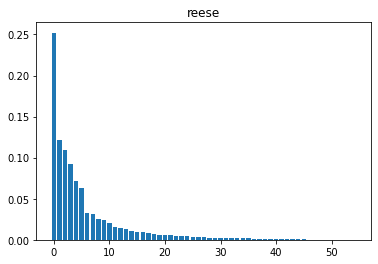

0.9999999999999997 55
3.9096136706687186


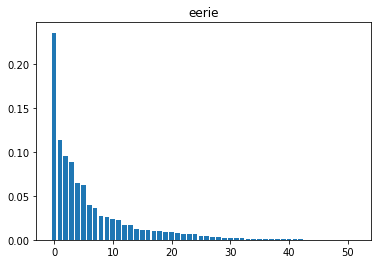

1.0 52
4.046266815125485


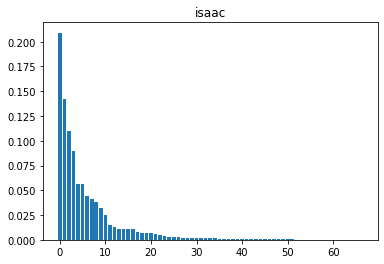

0.9999999999999994 67
4.030514444154017


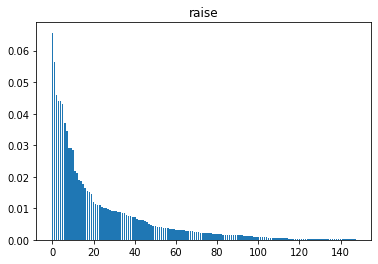

0.9999999999999991 148
5.921951204029759


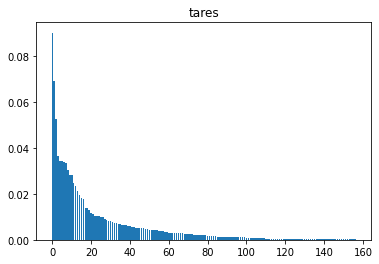

0.9999999999999994 157
5.874870792913259


In [7]:
for w in ['reese', 'eerie', 'isaac', 'raise', 'tares']:
    graph_outcomes(w)
    print(init_entropies[w])

### Wordle simulation

In [8]:
class Wordle:
    def __init__(self, corpus):
        self.corpus = corpus.copy()
        self.curr_word = None
        self.num_guesses = 0
    
    def new_game(self, debug_log=False):
        if not self.corpus:
            return None
        self.curr_word = random.choice(self.corpus)
        self.num_guesses = 0
        self.corpus.remove(self.curr_word)
        if debug_log:
            print(f'{len(self.corpus)} left after this word.')
        return self.curr_word
    
    def guess(self, guess):
        if not self.curr_word:
            raise ValueError('new game needs to be started before guessing')
        counter = Counter(self.curr_word)
        outcome = []
        to_fill = []
        for location, guess_letter in enumerate(guess):
            if guess_letter == self.curr_word[location]:
                outcome += [2]
                counter[guess_letter] -= 1
            elif guess_letter not in counter:
                outcome += [0]
            else:
                to_fill += [location]
                outcome += [None]
#         print(to_fill, counter)
        for location in to_fill:
            guess_letter = guess[location]
            if counter[guess_letter] >= 1:
                outcome[location] = 1
                counter[guess_letter] -= 1
            else:
                outcome[location] = 0
        self.num_guesses += 1
        guess_is_successful = outcome == [2] * 5
        if guess_is_successful:
            self.curr_word = None
        return guess_is_successful, outcome

In [9]:
# wordle tests
wordle = Wordle(corpus=five_letter_words)
wordle.curr_word = 'levee'
assert wordle.guess('eeeee') == (False, [0, 2, 0, 2, 2])
assert wordle.guess('velee') == (False, [1, 2, 1, 2, 2])
assert wordle.guess('veeez') == (False, [1, 2, 1, 2, 0])
assert wordle.guess('lllll') == (False, [2, 0, 0, 0, 0])
assert wordle.guess('zllll') == (False, [0, 1, 0, 0, 0])
assert wordle.guess('ezezz') == (False, [1, 0, 1, 0, 0])
assert wordle.num_guesses == 6
wordle.curr_word = 'abcde'
assert wordle.guess('edcba') == (False, [1, 1, 2, 1, 1])
assert wordle.guess('zzcba') == (False, [0, 0, 2, 1, 1])
assert wordle.guess('abcde') == (True, [2, 2, 2, 2, 2])
assert wordle.curr_word is None

In [10]:
# solver tests
corpus = ['abcde', 'eycby', 'excbx', 'excbd', 'excxx', 'ebcxx', 'eycyy']
assert get_possibilities('abcde', [0, 1, 2, 0, 1], corpus) == ['eycby', 'excbx']
assert get_possibilities('excbx', [2, 1, 2, 1, 2], corpus) == ['ebcxx']
# assert get_possibilities('abcde', [0, 1, 0, 0, 0], ['bxbbb']) == ['bxbbb']
assert get_possibilities('gases', [0, 2, 0, 2, 2], ['gases', 'james', 'oases', 'hades']) == ['james', 'hades']
corpus = ['ggggg', 'zzggg', 'zzzgg', 'zzzzg']
assert get_possibilities('ggaaa', [1, 1, 0, 0, 0], corpus) == ['zzggg', 'zzzgg']
assert get_possibilities('gggaa', [1, 1, 0, 0, 0], corpus) == ['zzzgg']
assert get_possibilities('raise', [0, 0, 0, 0, 1], ['kneed']) == ['kneed']
assert get_possibilities('reese', [0, 1, 2, 0, 2], ['ezeze', 'ezeee']) == ['ezeze', 'ezeee']


In [13]:
wordle = Wordle(corpus=five_letter_words)
num_tries = {}
entropies = {}
target = wordle.new_game()
while target is not None:
    corpus = five_letter_words
    # init_best_guess obtained previously over the whole corpus, does not change with target
    best_guess = init_best_guess
    guess_is_successful = False
    while not guess_is_successful:
        guess_is_successful, outcome = wordle.guess(best_guess)
        print('TARGET: ', target, '| GUESS: ', best_guess, '| OUTCOME: ', outcome)
        if guess_is_successful:
            num_tries[target] = wordle.num_guesses
            print('GOT IT!: ', wordle.num_guesses, 'tries')
            break # not super necessary?
        corpus = get_possibilities(best_guess, outcome, corpus)
        prev_guess = best_guess # for logging entropies only
        if wordle.num_guesses == 1:
            best_guess, guess_entropies = load_or_calculate_entropies(best_guess, outcome)
        else:
            best_guess, guess_entropies = get_best_guess(corpus)
        entropies[(target, prev_guess, wordle.num_guesses)] = guess_entropies
    target = wordle.new_game(debug_log=True)    

TARGET:  tiber | GUESS:  raise | OUTCOME:  [1, 0, 1, 0, 1]
loaded entropies from file
TARGET:  tiber | GUESS:  diner | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 10 words
TARGET:  tiber | GUESS:  giver | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 6 words
TARGET:  tiber | GUESS:  fiber | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  tiber | GUESS:  tiber | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
3576 left after this word.
TARGET:  blink | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 0]
loaded entropies from file
TARGET:  blink | GUESS:  clint | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 5 words
TARGET:  blink | GUESS:  blind | OUTCOME:  [2, 2, 2, 2, 0]
getting entropies for 2 words
TARGET:  blink | GUESS:  blinn | OUTCOME:  [2, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  blink | GUESS:  blink | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
3575 left after this word.
TARGET:  weedy | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file

loaded entropies from file
TARGET:  floor | GUESS:  court | OUTCOME:  [0, 1, 0, 1, 0]
getting entropies for 24 words
TARGET:  floor | GUESS:  frond | OUTCOME:  [2, 1, 2, 0, 0]
getting entropies for 1 words
TARGET:  floor | GUESS:  floor | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3553 left after this word.
TARGET:  spate | GUESS:  raise | OUTCOME:  [0, 1, 0, 1, 2]
loaded entropies from file
TARGET:  spate | GUESS:  slate | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 3 words
TARGET:  spate | GUESS:  spate | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3552 left after this word.
TARGET:  delft | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  delft | GUESS:  elton | OUTCOME:  [1, 1, 1, 0, 0]
getting entropies for 5 words
TARGET:  delft | GUESS:  veldt | OUTCOME:  [0, 2, 2, 1, 2]
getting entropies for 1 words
TARGET:  delft | GUESS:  delft | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3551 left after this word.
TARGET:  growl | GUESS:  raise | OUTCOME:  

loaded entropies from file
TARGET:  leafy | GUESS:  leant | OUTCOME:  [2, 2, 2, 0, 0]
getting entropies for 3 words
TARGET:  leafy | GUESS:  leaky | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  leafy | GUESS:  leafy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3525 left after this word.
TARGET:  silas | GUESS:  raise | OUTCOME:  [0, 1, 1, 1, 0]
loaded entropies from file
TARGET:  silas | GUESS:  snail | OUTCOME:  [2, 0, 1, 1, 1]
getting entropies for 2 words
TARGET:  silas | GUESS:  silas | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3524 left after this word.
TARGET:  lanka | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  lanka | GUESS:  tanya | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 6 words
TARGET:  lanka | GUESS:  manna | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 2 words
TARGET:  lanka | GUESS:  lanka | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3523 left after this word.
TARGET:  drupe | GUESS:  raise | OUTCOME:  [

loaded entropies from file
TARGET:  derek | GUESS:  tenor | OUTCOME:  [0, 2, 0, 0, 1]
getting entropies for 20 words
TARGET:  derek | GUESS:  percy | OUTCOME:  [0, 2, 2, 0, 0]
getting entropies for 1 words
TARGET:  derek | GUESS:  derek | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3498 left after this word.
TARGET:  covet | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  covet | GUESS:  elton | OUTCOME:  [1, 0, 1, 1, 0]
getting entropies for 4 words
TARGET:  covet | GUESS:  covet | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3497 left after this word.
TARGET:  stash | GUESS:  raise | OUTCOME:  [0, 1, 0, 2, 0]
loaded entropies from file
TARGET:  stash | GUESS:  slash | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 3 words
TARGET:  stash | GUESS:  smash | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 2 words
TARGET:  stash | GUESS:  stash | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3496 left after this word.
TARGET:  aisle | GUESS:  raise | OUTCOME:  

loaded entropies from file
TARGET:  bowie | GUESS:  belie | OUTCOME:  [2, 0, 0, 2, 2]
getting entropies for 1 words
TARGET:  bowie | GUESS:  bowie | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3468 left after this word.
TARGET:  utter | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  utter | GUESS:  tenor | OUTCOME:  [1, 1, 0, 0, 2]
getting entropies for 2 words
TARGET:  utter | GUESS:  utter | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3467 left after this word.
TARGET:  usual | GUESS:  raise | OUTCOME:  [0, 1, 0, 1, 0]
loaded entropies from file
TARGET:  usual | GUESS:  slant | OUTCOME:  [1, 1, 1, 0, 0]
getting entropies for 2 words
TARGET:  usual | GUESS:  usual | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3466 left after this word.
TARGET:  scout | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 0]
loaded entropies from file
TARGET:  scout | GUESS:  stunk | OUTCOME:  [2, 1, 1, 0, 0]
getting entropies for 3 words
TARGET:  scout | GUESS:  spout | OUTCOME:  [2, 

loaded entropies from file
TARGET:  happy | GUESS:  tanya | OUTCOME:  [0, 2, 0, 1, 0]
getting entropies for 26 words
TARGET:  happy | GUESS:  baldy | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 8 words
TARGET:  happy | GUESS:  jacky | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 4 words
TARGET:  happy | GUESS:  happy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
3441 left after this word.
TARGET:  aruba | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 0]
loaded entropies from file
TARGET:  aruba | GUESS:  bract | OUTCOME:  [1, 2, 1, 0, 0]
getting entropies for 3 words
TARGET:  aruba | GUESS:  urban | OUTCOME:  [1, 2, 1, 1, 0]
getting entropies for 1 words
TARGET:  aruba | GUESS:  aruba | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3440 left after this word.
TARGET:  mateo | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 1]
loaded entropies from file
TARGET:  mateo | GUESS:  galen | OUTCOME:  [0, 2, 0, 2, 0]
getting entropies for 6 words
TARGET:  mateo | GUESS:  cameo | OUTCOME:  [0, 2, 1, 2, 2]

loaded entropies from file
TARGET:  intra | GUESS:  trail | OUTCOME:  [1, 1, 1, 1, 0]
getting entropies for 1 words
TARGET:  intra | GUESS:  intra | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3414 left after this word.
TARGET:  great | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 1]
loaded entropies from file
TARGET:  great | GUESS:  alert | OUTCOME:  [1, 0, 2, 1, 2]
getting entropies for 2 words
TARGET:  great | GUESS:  treat | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  great | GUESS:  great | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3413 left after this word.
TARGET:  trick | GUESS:  raise | OUTCOME:  [1, 0, 2, 0, 0]
loaded entropies from file
TARGET:  trick | GUESS:  print | OUTCOME:  [0, 2, 2, 0, 1]
getting entropies for 3 words
TARGET:  trick | GUESS:  trick | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3412 left after this word.
TARGET:  phlox | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  phlox | GUESS:  colby | OUTCOME:  [0, 

TARGET:  garry | GUESS:  party | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 6 words
TARGET:  garry | GUESS:  hardy | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 3 words
TARGET:  garry | GUESS:  barry | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  garry | GUESS:  marry | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  garry | GUESS:  garry | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  7 tries
3382 left after this word.
TARGET:  azure | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 2]
loaded entropies from file
TARGET:  azure | GUESS:  grace | OUTCOME:  [0, 1, 1, 0, 2]
getting entropies for 3 words
TARGET:  azure | GUESS:  andre | OUTCOME:  [2, 0, 0, 2, 2]
getting entropies for 1 words
TARGET:  azure | GUESS:  azure | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3381 left after this word.
TARGET:  oaken | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 1]
loaded entropies from file
TARGET:  oaken | GUESS:  galen | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 8 wor

TARGET:  somal | GUESS:  somal | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3354 left after this word.
TARGET:  weigh | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 1]
loaded entropies from file
TARGET:  weigh | GUESS:  edith | OUTCOME:  [1, 0, 2, 0, 2]
getting entropies for 4 words
TARGET:  weigh | GUESS:  weigh | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3353 left after this word.
TARGET:  cacao | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  cacao | GUESS:  tanya | OUTCOME:  [0, 2, 0, 0, 1]
getting entropies for 7 words
TARGET:  cacao | GUESS:  macaw | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  cacao | GUESS:  cacao | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3352 left after this word.
TARGET:  vitae | GUESS:  raise | OUTCOME:  [0, 1, 1, 0, 2]
loaded entropies from file
TARGET:  vitae | GUESS:  angie | OUTCOME:  [1, 0, 0, 1, 2]
getting entropies for 1 words
TARGET:  vitae | GUESS:  vitae | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tri

TARGET:  graph | GUESS:  drank | OUTCOME:  [0, 2, 2, 0, 0]
getting entropies for 3 words
TARGET:  graph | GUESS:  gravy | OUTCOME:  [2, 2, 2, 0, 0]
getting entropies for 2 words
TARGET:  graph | GUESS:  graph | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
3328 left after this word.
TARGET:  pansy | GUESS:  raise | OUTCOME:  [0, 2, 0, 2, 0]
loaded entropies from file
TARGET:  pansy | GUESS:  palsy | OUTCOME:  [2, 2, 0, 2, 2]
getting entropies for 2 words
TARGET:  pansy | GUESS:  pansy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3327 left after this word.
TARGET:  proud | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  proud | GUESS:  court | OUTCOME:  [0, 1, 1, 1, 0]
getting entropies for 7 words
TARGET:  proud | GUESS:  juror | OUTCOME:  [0, 1, 1, 1, 0]
getting entropies for 3 words
TARGET:  proud | GUESS:  proud | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3326 left after this word.
TARGET:  ingot | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 0]
loaded entro

TARGET:  gabon | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  gabon | GUESS:  tanya | OUTCOME:  [0, 2, 1, 0, 0]
getting entropies for 6 words
TARGET:  gabon | GUESS:  macon | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 2 words
TARGET:  gabon | GUESS:  gabon | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3300 left after this word.
TARGET:  suing | GUESS:  raise | OUTCOME:  [0, 0, 2, 1, 0]
loaded entropies from file
TARGET:  suing | GUESS:  stink | OUTCOME:  [2, 0, 2, 2, 0]
getting entropies for 5 words
TARGET:  suing | GUESS:  sling | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 2 words
TARGET:  suing | GUESS:  swing | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  suing | GUESS:  suing | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
3299 left after this word.
TARGET:  icing | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 0]
loaded entropies from file
TARGET:  icing | GUESS:  clint | OUTCOME:  [1, 0, 2, 2, 0]
getting entropies for 1 words


TARGET:  degum | GUESS:  geeky | OUTCOME:  [1, 2, 0, 0, 0]
getting entropies for 2 words
TARGET:  degum | GUESS:  degum | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3274 left after this word.
TARGET:  elsie | GUESS:  raise | OUTCOME:  [0, 0, 1, 1, 2]
loaded entropies from file
TARGET:  elsie | GUESS:  siege | OUTCOME:  [1, 1, 1, 0, 2]
getting entropies for 1 words
TARGET:  elsie | GUESS:  elsie | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3273 left after this word.
TARGET:  whack | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  whack | GUESS:  tonal | OUTCOME:  [0, 0, 0, 1, 0]
getting entropies for 9 words
TARGET:  whack | GUESS:  yucca | OUTCOME:  [0, 0, 0, 2, 1]
getting entropies for 2 words
TARGET:  whack | GUESS:  aback | OUTCOME:  [0, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  whack | GUESS:  whack | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
3272 left after this word.
TARGET:  retry | GUESS:  raise | OUTCOME:  [2, 0, 0, 0, 1]
loaded entro

TARGET:  manga | GUESS:  manna | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  manga | GUESS:  manga | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3245 left after this word.
TARGET:  smack | GUESS:  raise | OUTCOME:  [0, 1, 0, 1, 0]
loaded entropies from file
TARGET:  smack | GUESS:  slant | OUTCOME:  [2, 0, 2, 0, 0]
getting entropies for 9 words
TARGET:  smack | GUESS:  smack | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3244 left after this word.
TARGET:  human | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  human | GUESS:  tonal | OUTCOME:  [0, 0, 1, 2, 0]
getting entropies for 6 words
TARGET:  human | GUESS:  hyman | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  human | GUESS:  human | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3243 left after this word.
TARGET:  third | GUESS:  raise | OUTCOME:  [1, 0, 2, 0, 0]
loaded entropies from file
TARGET:  third | GUESS:  print | OUTCOME:  [0, 1, 2, 0, 1]
getting entropi

loaded entropies from file
TARGET:  cutie | GUESS:  belie | OUTCOME:  [0, 0, 0, 2, 2]
getting entropies for 5 words
TARGET:  cutie | GUESS:  dixie | OUTCOME:  [0, 0, 0, 2, 2]
getting entropies for 3 words
TARGET:  cutie | GUESS:  cutie | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3219 left after this word.
TARGET:  close | GUESS:  raise | OUTCOME:  [0, 0, 0, 2, 2]
loaded entropies from file
TARGET:  close | GUESS:  house | OUTCOME:  [0, 1, 0, 2, 2]
getting entropies for 2 words
TARGET:  close | GUESS:  close | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3218 left after this word.
TARGET:  scary | GUESS:  raise | OUTCOME:  [1, 1, 0, 1, 0]
loaded entropies from file
TARGET:  scary | GUESS:  strap | OUTCOME:  [2, 0, 1, 1, 0]
getting entropies for 7 words
TARGET:  scary | GUESS:  shark | OUTCOME:  [2, 0, 2, 2, 0]
getting entropies for 4 words
TARGET:  scary | GUESS:  scarf | OUTCOME:  [2, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  scary | GUESS:  scary | OUTCOME:  [2, 2, 2, 2, 2]


loaded entropies from file
TARGET:  ellis | GUESS:  sinew | OUTCOME:  [1, 1, 0, 1, 0]
getting entropies for 2 words
TARGET:  ellis | GUESS:  levis | OUTCOME:  [1, 1, 0, 2, 2]
getting entropies for 1 words
TARGET:  ellis | GUESS:  ellis | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3192 left after this word.
TARGET:  anise | GUESS:  raise | OUTCOME:  [0, 1, 2, 2, 2]
loaded entropies from file
TARGET:  anise | GUESS:  anise | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  2 tries
3191 left after this word.
TARGET:  hadnt | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  hadnt | GUESS:  tanya | OUTCOME:  [1, 2, 1, 0, 0]
getting entropies for 7 words
TARGET:  hadnt | GUESS:  hadnt | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3190 left after this word.
TARGET:  tried | GUESS:  raise | OUTCOME:  [1, 0, 2, 0, 1]
loaded entropies from file
TARGET:  tried | GUESS:  fried | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 4 words
TARGET:  tried | GUESS:  cried | OUTCOME:  [0, 

TARGET:  louse | GUESS:  mouse | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  louse | GUESS:  douse | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  louse | GUESS:  louse | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
3162 left after this word.
TARGET:  colby | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  colby | GUESS:  colby | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  2 tries
3161 left after this word.
TARGET:  peter | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  peter | GUESS:  tenor | OUTCOME:  [1, 2, 0, 0, 2]
getting entropies for 3 words
TARGET:  peter | GUESS:  deter | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  peter | GUESS:  peter | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3160 left after this word.
TARGET:  leggy | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  leggy | GUESS:  elton | OUTCOME:  [1, 1, 0, 0, 0]
getting entropi

TARGET:  poker | GUESS:  mower | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 9 words
TARGET:  poker | GUESS:  cover | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 5 words
TARGET:  poker | GUESS:  foyer | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 3 words
TARGET:  poker | GUESS:  joker | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  poker | GUESS:  poker | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  7 tries
3137 left after this word.
TARGET:  muddy | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  muddy | GUESS:  colby | OUTCOME:  [0, 0, 0, 0, 2]
getting entropies for 23 words
TARGET:  muddy | GUESS:  dumpy | OUTCOME:  [1, 2, 1, 0, 2]
getting entropies for 1 words
TARGET:  muddy | GUESS:  muddy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3136 left after this word.
TARGET:  mucky | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  mucky | GUESS:  colby | OUTCOME:  [1, 0, 0, 0, 2]
getting entropies for 2 wo

loaded entropies from file
TARGET:  glans | GUESS:  slant | OUTCOME:  [1, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  glans | GUESS:  glans | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3110 left after this word.
TARGET:  grass | GUESS:  raise | OUTCOME:  [1, 1, 0, 2, 0]
loaded entropies from file
TARGET:  grass | GUESS:  brass | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  grass | GUESS:  grass | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3109 left after this word.
TARGET:  goner | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  goner | GUESS:  tenor | OUTCOME:  [0, 1, 2, 1, 2]
getting entropies for 2 words
TARGET:  goner | GUESS:  goner | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3108 left after this word.
TARGET:  blatz | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  blatz | GUESS:  tonal | OUTCOME:  [1, 0, 0, 1, 1]
getting entropies for 3 words
TARGET:  blatz | GUESS:  adult | OUTCOME:  [1, 

TARGET:  clock | GUESS:  clout | OUTCOME:  [2, 2, 2, 0, 0]
getting entropies for 3 words
TARGET:  clock | GUESS:  clown | OUTCOME:  [2, 2, 2, 0, 0]
getting entropies for 2 words
TARGET:  clock | GUESS:  clock | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
3080 left after this word.
TARGET:  claus | GUESS:  raise | OUTCOME:  [0, 1, 0, 1, 0]
loaded entropies from file
TARGET:  claus | GUESS:  slant | OUTCOME:  [1, 2, 2, 0, 0]
getting entropies for 2 words
TARGET:  claus | GUESS:  claus | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3079 left after this word.
TARGET:  tizzy | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 0]
loaded entropies from file
TARGET:  tizzy | GUESS:  tonic | OUTCOME:  [2, 0, 0, 1, 0]
getting entropies for 4 words
TARGET:  tizzy | GUESS:  tilth | OUTCOME:  [2, 2, 0, 0, 0]
getting entropies for 2 words
TARGET:  tizzy | GUESS:  tizzy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3078 left after this word.
TARGET:  ivory | GUESS:  raise | OUTCOME:  [1, 0, 1, 0, 0]
loaded entro

TARGET:  caleb | GUESS:  daley | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 2 words
TARGET:  caleb | GUESS:  caleb | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3056 left after this word.
TARGET:  homer | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  homer | GUESS:  tenor | OUTCOME:  [0, 1, 0, 1, 2]
getting entropies for 21 words
TARGET:  homer | GUESS:  mower | OUTCOME:  [1, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  homer | GUESS:  homer | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3055 left after this word.
TARGET:  stock | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 0]
loaded entropies from file
TARGET:  stock | GUESS:  stunk | OUTCOME:  [2, 2, 0, 0, 2]
getting entropies for 1 words
TARGET:  stock | GUESS:  stock | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3054 left after this word.
TARGET:  juicy | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 0]
loaded entropies from file
TARGET:  juicy | GUESS:  clint | OUTCOME:  [1, 0, 2, 0, 0]
getting entrop

TARGET:  fugue | GUESS:  judge | OUTCOME:  [0, 2, 0, 1, 2]
getting entropies for 1 words
TARGET:  fugue | GUESS:  fugue | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
3029 left after this word.
TARGET:  spent | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 1]
loaded entropies from file
TARGET:  spent | GUESS:  upset | OUTCOME:  [0, 2, 1, 1, 2]
getting entropies for 2 words
TARGET:  spent | GUESS:  spent | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
3028 left after this word.
TARGET:  suave | GUESS:  raise | OUTCOME:  [0, 1, 0, 1, 2]
loaded entropies from file
TARGET:  suave | GUESS:  slate | OUTCOME:  [2, 0, 2, 0, 2]
getting entropies for 9 words
TARGET:  suave | GUESS:  spade | OUTCOME:  [2, 0, 2, 0, 2]
getting entropies for 5 words
TARGET:  suave | GUESS:  shake | OUTCOME:  [2, 0, 2, 0, 2]
getting entropies for 1 words
TARGET:  suave | GUESS:  suave | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
3027 left after this word.
TARGET:  chile | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 2]
loaded entro

loaded entropies from file
TARGET:  allah | GUESS:  tonal | OUTCOME:  [0, 0, 0, 2, 1]
getting entropies for 4 words
TARGET:  allah | GUESS:  allay | OUTCOME:  [2, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  allah | GUESS:  allah | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2999 left after this word.
TARGET:  abled | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 1]
loaded entropies from file
TARGET:  abled | GUESS:  leant | OUTCOME:  [1, 1, 1, 0, 0]
getting entropies for 8 words
TARGET:  abled | GUESS:  aleck | OUTCOME:  [2, 1, 1, 0, 0]
getting entropies for 1 words
TARGET:  abled | GUESS:  abled | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2998 left after this word.
TARGET:  twist | GUESS:  raise | OUTCOME:  [0, 0, 2, 2, 0]
loaded entropies from file
TARGET:  twist | GUESS:  swish | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  twist | GUESS:  twist | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2997 left after this word.
TARGET:  poppy | GUESS:  raise | OUTCOME:  [

TARGET:  drape | GUESS:  drake | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  drape | GUESS:  drape | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2972 left after this word.
TARGET:  rebut | GUESS:  raise | OUTCOME:  [2, 0, 0, 0, 1]
loaded entropies from file
TARGET:  rebut | GUESS:  recur | OUTCOME:  [2, 2, 0, 2, 0]
getting entropies for 1 words
TARGET:  rebut | GUESS:  rebut | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2971 left after this word.
TARGET:  waver | GUESS:  raise | OUTCOME:  [1, 2, 0, 0, 1]
loaded entropies from file
TARGET:  waver | GUESS:  taper | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 16 words
TARGET:  waver | GUESS:  lager | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 7 words
TARGET:  waver | GUESS:  baker | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 3 words
TARGET:  waver | GUESS:  wafer | OUTCOME:  [2, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  waver | GUESS:  waver | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  6 tries
2970 lef

loaded entropies from file
TARGET:  burtt | GUESS:  court | OUTCOME:  [0, 0, 1, 1, 2]
getting entropies for 2 words
TARGET:  burtt | GUESS:  burnt | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  burtt | GUESS:  burtt | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2946 left after this word.
TARGET:  gouge | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 2]
loaded entropies from file
TARGET:  gouge | GUESS:  ecole | OUTCOME:  [0, 0, 1, 0, 2]
getting entropies for 8 words
TARGET:  gouge | GUESS:  hodge | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  gouge | GUESS:  gouge | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2945 left after this word.
TARGET:  brick | GUESS:  raise | OUTCOME:  [1, 0, 2, 0, 0]
loaded entropies from file
TARGET:  brick | GUESS:  print | OUTCOME:  [0, 2, 2, 0, 0]
getting entropies for 9 words
TARGET:  brick | GUESS:  frick | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  brick | GUESS:  brick | OUTCOME:  [2, 2, 2, 2, 2]


TARGET:  byron | GUESS:  frond | OUTCOME:  [0, 1, 1, 1, 0]
getting entropies for 2 words
TARGET:  byron | GUESS:  myron | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  byron | GUESS:  byron | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
2923 left after this word.
TARGET:  chaos | GUESS:  raise | OUTCOME:  [0, 1, 0, 1, 0]
loaded entropies from file
TARGET:  chaos | GUESS:  slant | OUTCOME:  [1, 0, 2, 0, 0]
getting entropies for 2 words
TARGET:  chaos | GUESS:  osaka | OUTCOME:  [1, 1, 2, 0, 0]
getting entropies for 1 words
TARGET:  chaos | GUESS:  chaos | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2922 left after this word.
TARGET:  tawny | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  tawny | GUESS:  tanya | OUTCOME:  [2, 2, 1, 1, 0]
getting entropies for 1 words
TARGET:  tawny | GUESS:  tawny | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2921 left after this word.
TARGET:  syria | GUESS:  raise | OUTCOME:  [1, 1, 1, 1, 0]
loaded entro

loaded entropies from file
TARGET:  hertz | GUESS:  tenor | OUTCOME:  [1, 2, 0, 0, 1]
getting entropies for 4 words
TARGET:  hertz | GUESS:  berth | OUTCOME:  [0, 2, 2, 2, 1]
getting entropies for 1 words
TARGET:  hertz | GUESS:  hertz | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2892 left after this word.
TARGET:  hydra | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 0]
loaded entropies from file
TARGET:  hydra | GUESS:  bract | OUTCOME:  [0, 1, 1, 0, 0]
getting entropies for 20 words
TARGET:  hydra | GUESS:  moran | OUTCOME:  [0, 0, 1, 1, 0]
getting entropies for 2 words
TARGET:  hydra | GUESS:  hydra | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2891 left after this word.
TARGET:  triad | GUESS:  raise | OUTCOME:  [1, 1, 2, 0, 0]
loaded entropies from file
TARGET:  triad | GUESS:  briar | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 3 words
TARGET:  triad | GUESS:  triad | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2890 left after this word.
TARGET:  hubby | GUESS:  raise | OUTCOME:  

TARGET:  garth | GUESS:  party | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 2 words
TARGET:  garth | GUESS:  barth | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  garth | GUESS:  garth | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
2865 left after this word.
TARGET:  seize | GUESS:  raise | OUTCOME:  [0, 0, 2, 1, 2]
loaded entropies from file
TARGET:  seize | GUESS:  snipe | OUTCOME:  [2, 0, 2, 0, 2]
getting entropies for 8 words
TARGET:  seize | GUESS:  slime | OUTCOME:  [2, 0, 2, 0, 2]
getting entropies for 2 words
TARGET:  seize | GUESS:  seize | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2864 left after this word.
TARGET:  slant | GUESS:  raise | OUTCOME:  [0, 1, 0, 1, 0]
loaded entropies from file
TARGET:  slant | GUESS:  slant | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  2 tries
2863 left after this word.
TARGET:  greet | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  greet | GUESS:  tenor | OUTCOME:  [1, 1, 0, 0, 1]
getting entropi

TARGET:  askew | GUESS:  askew | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2841 left after this word.
TARGET:  nehru | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  nehru | GUESS:  tenor | OUTCOME:  [0, 2, 1, 0, 1]
getting entropies for 2 words
TARGET:  nehru | GUESS:  nehru | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2840 left after this word.
TARGET:  freud | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  freud | GUESS:  tenor | OUTCOME:  [0, 1, 0, 0, 1]
getting entropies for 18 words
TARGET:  freud | GUESS:  creed | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  freud | GUESS:  freud | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2839 left after this word.
TARGET:  coney | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  coney | GUESS:  elton | OUTCOME:  [1, 0, 0, 1, 1]
getting entropies for 5 words
TARGET:  coney | GUESS:  coney | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tr

loaded entropies from file
TARGET:  bumpy | GUESS:  colby | OUTCOME:  [0, 0, 0, 1, 2]
getting entropies for 6 words
TARGET:  bumpy | GUESS:  bundy | OUTCOME:  [2, 2, 0, 0, 2]
getting entropies for 3 words
TARGET:  bumpy | GUESS:  buzzy | OUTCOME:  [2, 2, 0, 0, 2]
getting entropies for 2 words
TARGET:  bumpy | GUESS:  bumpy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
2813 left after this word.
TARGET:  marcy | GUESS:  raise | OUTCOME:  [1, 2, 0, 0, 0]
loaded entropies from file
TARGET:  marcy | GUESS:  carol | OUTCOME:  [1, 2, 2, 0, 0]
getting entropies for 3 words
TARGET:  marcy | GUESS:  marcy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2812 left after this word.
TARGET:  typic | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 0]
loaded entropies from file
TARGET:  typic | GUESS:  tonic | OUTCOME:  [2, 0, 0, 2, 2]
getting entropies for 1 words
TARGET:  typic | GUESS:  typic | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2811 left after this word.
TARGET:  spitz | GUESS:  raise | OUTCOME:  [

loaded entropies from file
TARGET:  tamil | GUESS:  latin | OUTCOME:  [1, 2, 1, 2, 0]
getting entropies for 1 words
TARGET:  tamil | GUESS:  tamil | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2787 left after this word.
TARGET:  while | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 2]
loaded entropies from file
TARGET:  while | GUESS:  chile | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  while | GUESS:  while | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2786 left after this word.
TARGET:  brook | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  brook | GUESS:  court | OUTCOME:  [0, 1, 0, 1, 0]
getting entropies for 24 words
TARGET:  brook | GUESS:  frond | OUTCOME:  [0, 2, 2, 0, 0]
getting entropies for 6 words
TARGET:  brook | GUESS:  groom | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  brook | GUESS:  brook | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
2785 left after this word.
TARGET:  youre | GUESS:  raise | OUTCOME:  

TARGET:  wrest | GUESS:  wrest | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2754 left after this word.
TARGET:  later | GUESS:  raise | OUTCOME:  [1, 2, 0, 0, 1]
loaded entropies from file
TARGET:  later | GUESS:  taper | OUTCOME:  [1, 2, 0, 2, 2]
getting entropies for 8 words
TARGET:  later | GUESS:  water | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 7 words
TARGET:  later | GUESS:  later | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2753 left after this word.
TARGET:  moire | GUESS:  raise | OUTCOME:  [1, 0, 2, 0, 2]
loaded entropies from file
TARGET:  moire | GUESS:  tripe | OUTCOME:  [0, 1, 2, 0, 2]
getting entropies for 2 words
TARGET:  moire | GUESS:  loire | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  moire | GUESS:  moire | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2752 left after this word.
TARGET:  junta | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  junta | GUESS:  tonal | OUTCOME:  [1, 0, 2, 1, 0]
getting entropi

loaded entropies from file
TARGET:  clued | GUESS:  elton | OUTCOME:  [1, 2, 0, 0, 0]
getting entropies for 5 words
TARGET:  clued | GUESS:  bleed | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  clued | GUESS:  clued | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2729 left after this word.
TARGET:  denny | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  denny | GUESS:  elton | OUTCOME:  [1, 0, 0, 0, 1]
getting entropies for 13 words
TARGET:  denny | GUESS:  upend | OUTCOME:  [0, 0, 1, 2, 1]
getting entropies for 1 words
TARGET:  denny | GUESS:  denny | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2728 left after this word.
TARGET:  percy | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  percy | GUESS:  tenor | OUTCOME:  [0, 2, 0, 0, 1]
getting entropies for 20 words
TARGET:  percy | GUESS:  percy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2727 left after this word.
TARGET:  judge | GUESS:  raise | OUTCOME: 

loaded entropies from file
TARGET:  sprue | GUESS:  spree | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  sprue | GUESS:  sprue | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2700 left after this word.
TARGET:  thong | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  thong | GUESS:  colby | OUTCOME:  [0, 1, 0, 0, 0]
getting entropies for 13 words
TARGET:  thong | GUESS:  ought | OUTCOME:  [1, 0, 1, 1, 1]
getting entropies for 1 words
TARGET:  thong | GUESS:  thong | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2699 left after this word.
TARGET:  murky | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  murky | GUESS:  court | OUTCOME:  [0, 0, 1, 1, 0]
getting entropies for 2 words
TARGET:  murky | GUESS:  burly | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  murky | GUESS:  murky | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2698 left after this word.
TARGET:  lucia | GUESS:  raise | OUTCOME:  

loaded entropies from file
TARGET:  poser | GUESS:  senor | OUTCOME:  [1, 1, 0, 1, 2]
getting entropies for 3 words
TARGET:  poser | GUESS:  moser | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  poser | GUESS:  loser | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  poser | GUESS:  poser | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
2676 left after this word.
TARGET:  henry | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  henry | GUESS:  tenor | OUTCOME:  [0, 2, 2, 0, 1]
getting entropies for 1 words
TARGET:  henry | GUESS:  henry | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2675 left after this word.
TARGET:  ising | GUESS:  raise | OUTCOME:  [0, 0, 2, 1, 0]
loaded entropies from file
TARGET:  ising | GUESS:  stink | OUTCOME:  [1, 0, 2, 2, 0]
getting entropies for 2 words
TARGET:  ising | GUESS:  ising | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2674 left after this word.
TARGET:  canna | GUESS:  raise | OUTCOME:  [

TARGET:  grand | GUESS:  drank | OUTCOME:  [1, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  grand | GUESS:  grand | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2652 left after this word.
TARGET:  enjoy | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  enjoy | GUESS:  elton | OUTCOME:  [2, 0, 0, 2, 1]
getting entropies for 3 words
TARGET:  enjoy | GUESS:  envoy | OUTCOME:  [2, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  enjoy | GUESS:  enjoy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2651 left after this word.
TARGET:  unary | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 0]
loaded entropies from file
TARGET:  unary | GUESS:  bract | OUTCOME:  [0, 1, 2, 0, 0]
getting entropies for 11 words
TARGET:  unary | GUESS:  guard | OUTCOME:  [0, 1, 2, 2, 0]
getting entropies for 1 words
TARGET:  unary | GUESS:  unary | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2650 left after this word.
TARGET:  korea | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 1]
loaded entr

loaded entropies from file
TARGET:  knock | GUESS:  colby | OUTCOME:  [1, 1, 0, 0, 0]
getting entropies for 2 words
TARGET:  knock | GUESS:  junco | OUTCOME:  [0, 0, 1, 2, 1]
getting entropies for 1 words
TARGET:  knock | GUESS:  knock | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2625 left after this word.
TARGET:  tansy | GUESS:  raise | OUTCOME:  [0, 2, 0, 2, 0]
loaded entropies from file
TARGET:  tansy | GUESS:  palsy | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 3 words
TARGET:  tansy | GUESS:  gassy | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  tansy | GUESS:  tansy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2624 left after this word.
TARGET:  vital | GUESS:  raise | OUTCOME:  [0, 1, 1, 0, 0]
loaded entropies from file
TARGET:  vital | GUESS:  plain | OUTCOME:  [0, 1, 1, 1, 0]
getting entropies for 8 words
TARGET:  vital | GUESS:  villa | OUTCOME:  [2, 2, 1, 0, 1]
getting entropies for 1 words
TARGET:  vital | GUESS:  vital | OUTCOME:  [2, 2, 2, 2, 2]


TARGET:  flame | GUESS:  blame | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  flame | GUESS:  flame | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2598 left after this word.
TARGET:  snafu | GUESS:  raise | OUTCOME:  [0, 1, 0, 1, 0]
loaded entropies from file
TARGET:  snafu | GUESS:  slant | OUTCOME:  [2, 0, 2, 1, 0]
getting entropies for 4 words
TARGET:  snafu | GUESS:  snack | OUTCOME:  [2, 2, 2, 0, 0]
getting entropies for 1 words
TARGET:  snafu | GUESS:  snafu | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2597 left after this word.
TARGET:  lykes | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 1]
loaded entropies from file
TARGET:  lykes | GUESS:  upset | OUTCOME:  [0, 0, 1, 2, 0]
getting entropies for 10 words
TARGET:  lykes | GUESS:  sleek | OUTCOME:  [1, 1, 0, 2, 1]
getting entropies for 1 words
TARGET:  lykes | GUESS:  lykes | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2596 left after this word.
TARGET:  flash | GUESS:  raise | OUTCOME:  [0, 1, 0, 2, 0]
loaded entr

TARGET:  idyll | GUESS:  filmy | OUTCOME:  [0, 1, 1, 0, 1]
getting entropies for 1 words
TARGET:  idyll | GUESS:  idyll | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2572 left after this word.
TARGET:  dylan | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  dylan | GUESS:  tonal | OUTCOME:  [0, 0, 1, 2, 1]
getting entropies for 3 words
TARGET:  dylan | GUESS:  allan | OUTCOME:  [0, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  dylan | GUESS:  dylan | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2571 left after this word.
TARGET:  cecil | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 1]
loaded entropies from file
TARGET:  cecil | GUESS:  liven | OUTCOME:  [1, 1, 0, 1, 0]
getting entropies for 5 words
TARGET:  cecil | GUESS:  delhi | OUTCOME:  [0, 2, 1, 0, 1]
getting entropies for 1 words
TARGET:  cecil | GUESS:  cecil | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2570 left after this word.
TARGET:  whisk | GUESS:  raise | OUTCOME:  [0, 0, 2, 2, 0]
loaded entro

TARGET:  hodge | GUESS:  hodge | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2545 left after this word.
TARGET:  annal | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  annal | GUESS:  tonal | OUTCOME:  [0, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  annal | GUESS:  annal | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2544 left after this word.
TARGET:  groom | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  groom | GUESS:  court | OUTCOME:  [0, 1, 0, 1, 0]
getting entropies for 24 words
TARGET:  groom | GUESS:  frond | OUTCOME:  [0, 2, 2, 0, 0]
getting entropies for 6 words
TARGET:  groom | GUESS:  groom | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2543 left after this word.
TARGET:  dowdy | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  dowdy | GUESS:  colby | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 17 words
TARGET:  dowdy | GUESS:  moody | OUTCOME:  [0, 2, 0, 2, 2]
getting entro

TARGET:  flack | GUESS:  clamp | OUTCOME:  [1, 2, 2, 0, 0]
getting entropies for 2 words
TARGET:  flack | GUESS:  black | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  flack | GUESS:  flack | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
2520 left after this word.
TARGET:  prude | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 2]
loaded entropies from file
TARGET:  prude | GUESS:  crete | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 12 words
TARGET:  prude | GUESS:  prune | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  prude | GUESS:  prude | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2519 left after this word.
TARGET:  halma | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  halma | GUESS:  tanya | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 14 words
TARGET:  halma | GUESS:  paula | OUTCOME:  [0, 2, 0, 1, 2]
getting entropies for 1 words
TARGET:  halma | GUESS:  halma | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2518 le

TARGET:  catty | GUESS:  cathy | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  catty | GUESS:  catty | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2493 left after this word.
TARGET:  round | GUESS:  raise | OUTCOME:  [2, 0, 0, 0, 0]
loaded entropies from file
TARGET:  round | GUESS:  runty | OUTCOME:  [2, 1, 1, 0, 0]
getting entropies for 1 words
TARGET:  round | GUESS:  round | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2492 left after this word.
TARGET:  chase | GUESS:  raise | OUTCOME:  [0, 1, 0, 2, 2]
loaded entropies from file
TARGET:  chase | GUESS:  cease | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  chase | GUESS:  chase | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2491 left after this word.
TARGET:  elena | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 1]
loaded entropies from file
TARGET:  elena | GUESS:  leant | OUTCOME:  [1, 1, 1, 2, 0]
getting entropies for 1 words
TARGET:  elena | GUESS:  elena | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tri

TARGET:  bawdy | GUESS:  baldy | OUTCOME:  [2, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  bawdy | GUESS:  bawdy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2465 left after this word.
TARGET:  laura | GUESS:  raise | OUTCOME:  [1, 2, 0, 0, 0]
loaded entropies from file
TARGET:  laura | GUESS:  carol | OUTCOME:  [0, 2, 1, 0, 1]
getting entropies for 2 words
TARGET:  laura | GUESS:  laura | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2464 left after this word.
TARGET:  foamy | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  foamy | GUESS:  tonal | OUTCOME:  [0, 2, 0, 1, 0]
getting entropies for 11 words
TARGET:  foamy | GUESS:  comma | OUTCOME:  [0, 2, 0, 2, 1]
getting entropies for 1 words
TARGET:  foamy | GUESS:  foamy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2463 left after this word.
TARGET:  jacob | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  jacob | GUESS:  tanya | OUTCOME:  [0, 2, 0, 0, 0]
getting entrop

loaded entropies from file
TARGET:  burma | GUESS:  bract | OUTCOME:  [2, 1, 1, 0, 0]
getting entropies for 3 words
TARGET:  burma | GUESS:  burma | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2442 left after this word.
TARGET:  boney | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  boney | GUESS:  elton | OUTCOME:  [1, 0, 0, 1, 1]
getting entropies for 5 words
TARGET:  boney | GUESS:  coney | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 3 words
TARGET:  boney | GUESS:  money | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  boney | GUESS:  honey | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  boney | GUESS:  boney | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  6 tries
2441 left after this word.
TARGET:  conic | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 0]
loaded entropies from file
TARGET:  conic | GUESS:  tonic | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 3 words
TARGET:  conic | GUESS:  monic | OUTCOME:  [0, 2, 2, 2, 2]


TARGET:  mummy | GUESS:  dumpy | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 2 words
TARGET:  mummy | GUESS:  mummy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2418 left after this word.
TARGET:  farce | GUESS:  raise | OUTCOME:  [1, 2, 0, 0, 2]
loaded entropies from file
TARGET:  farce | GUESS:  cadre | OUTCOME:  [1, 2, 0, 1, 2]
getting entropies for 1 words
TARGET:  farce | GUESS:  farce | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2417 left after this word.
TARGET:  dodge | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 2]
loaded entropies from file
TARGET:  dodge | GUESS:  ecole | OUTCOME:  [0, 0, 1, 0, 2]
getting entropies for 8 words
TARGET:  dodge | GUESS:  hodge | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  dodge | GUESS:  podge | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  dodge | GUESS:  dodge | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
2416 left after this word.
TARGET:  indus | GUESS:  raise | OUTCOME:  [0, 0, 1, 1, 0]
loaded entro

TARGET:  leigh | GUESS:  neigh | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  leigh | GUESS:  leigh | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
2390 left after this word.
TARGET:  logan | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  logan | GUESS:  tonal | OUTCOME:  [0, 2, 1, 2, 1]
getting entropies for 3 words
TARGET:  logan | GUESS:  dolan | OUTCOME:  [0, 2, 1, 2, 2]
getting entropies for 1 words
TARGET:  logan | GUESS:  logan | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2389 left after this word.
TARGET:  walla | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  walla | GUESS:  tanya | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 14 words
TARGET:  walla | GUESS:  paula | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 2 words
TARGET:  walla | GUESS:  calla | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  walla | GUESS:  walla | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
2388 lef

getting entropies for 1 words
TARGET:  natty | GUESS:  natty | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2363 left after this word.
TARGET:  impel | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 1]
loaded entropies from file
TARGET:  impel | GUESS:  liven | OUTCOME:  [1, 1, 0, 2, 0]
getting entropies for 1 words
TARGET:  impel | GUESS:  impel | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2362 left after this word.
TARGET:  chirp | GUESS:  raise | OUTCOME:  [1, 0, 2, 0, 0]
loaded entropies from file
TARGET:  chirp | GUESS:  print | OUTCOME:  [1, 1, 2, 0, 0]
getting entropies for 1 words
TARGET:  chirp | GUESS:  chirp | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2361 left after this word.
TARGET:  moser | GUESS:  raise | OUTCOME:  [1, 0, 0, 1, 1]
loaded entropies from file
TARGET:  moser | GUESS:  senor | OUTCOME:  [1, 1, 0, 1, 2]
getting entropies for 3 words
TARGET:  moser | GUESS:  moser | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2360 left after this word.
TARGET:  utica | GUESS:  rais

TARGET:  pudgy | GUESS:  dumpy | OUTCOME:  [1, 2, 0, 1, 2]
getting entropies for 1 words
TARGET:  pudgy | GUESS:  pudgy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2337 left after this word.
TARGET:  boggy | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  boggy | GUESS:  colby | OUTCOME:  [0, 2, 0, 1, 2]
getting entropies for 4 words
TARGET:  boggy | GUESS:  booty | OUTCOME:  [2, 2, 0, 0, 2]
getting entropies for 1 words
TARGET:  boggy | GUESS:  boggy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2336 left after this word.
TARGET:  basic | GUESS:  raise | OUTCOME:  [0, 2, 1, 1, 0]
loaded entropies from file
TARGET:  basic | GUESS:  basin | OUTCOME:  [2, 2, 2, 2, 0]
getting entropies for 3 words
TARGET:  basic | GUESS:  basic | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2335 left after this word.
TARGET:  voila | GUESS:  raise | OUTCOME:  [0, 1, 2, 0, 0]
loaded entropies from file
TARGET:  voila | GUESS:  align | OUTCOME:  [1, 1, 2, 0, 0]
getting entropi

TARGET:  value | GUESS:  cable | OUTCOME:  [0, 2, 0, 1, 2]
getting entropies for 3 words
TARGET:  value | GUESS:  halve | OUTCOME:  [0, 2, 2, 1, 2]
getting entropies for 1 words
TARGET:  value | GUESS:  value | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
2309 left after this word.
TARGET:  hefty | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  hefty | GUESS:  elton | OUTCOME:  [1, 0, 1, 0, 0]
getting entropies for 14 words
TARGET:  hefty | GUESS:  depth | OUTCOME:  [0, 2, 0, 2, 1]
getting entropies for 1 words
TARGET:  hefty | GUESS:  hefty | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2308 left after this word.
TARGET:  masse | GUESS:  raise | OUTCOME:  [0, 2, 0, 2, 2]
loaded entropies from file
TARGET:  masse | GUESS:  pause | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 3 words
TARGET:  masse | GUESS:  manse | OUTCOME:  [2, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  masse | GUESS:  masse | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2307 lef

TARGET:  wince | GUESS:  tinge | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 2 words
TARGET:  wince | GUESS:  wince | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2284 left after this word.
TARGET:  maser | GUESS:  raise | OUTCOME:  [1, 2, 0, 1, 1]
loaded entropies from file
TARGET:  maser | GUESS:  safer | OUTCOME:  [1, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  maser | GUESS:  maser | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2283 left after this word.
TARGET:  evans | GUESS:  raise | OUTCOME:  [0, 1, 0, 1, 1]
loaded entropies from file
TARGET:  evans | GUESS:  sedan | OUTCOME:  [1, 1, 0, 1, 1]
getting entropies for 2 words
TARGET:  evans | GUESS:  evans | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2282 left after this word.
TARGET:  shako | GUESS:  raise | OUTCOME:  [0, 1, 0, 1, 0]
loaded entropies from file
TARGET:  shako | GUESS:  slant | OUTCOME:  [2, 0, 2, 0, 0]
getting entropies for 9 words
TARGET:  shako | GUESS:  smack | OUTCOME:  [2, 0, 2, 0, 1]
getting entropi

2259 left after this word.
TARGET:  piney | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 1]
loaded entropies from file
TARGET:  piney | GUESS:  liven | OUTCOME:  [0, 2, 0, 2, 1]
getting entropies for 1 words
TARGET:  piney | GUESS:  piney | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2258 left after this word.
TARGET:  style | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 2]
loaded entropies from file
TARGET:  style | GUESS:  stone | OUTCOME:  [2, 2, 0, 0, 2]
getting entropies for 2 words
TARGET:  style | GUESS:  style | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2257 left after this word.
TARGET:  godly | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  godly | GUESS:  colby | OUTCOME:  [0, 2, 1, 0, 2]
getting entropies for 7 words
TARGET:  godly | GUESS:  jowly | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 2 words
TARGET:  godly | GUESS:  godly | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2256 left after this word.
TARGET:  udder | GUESS:  raise | OUTCOME:  [1, 

loaded entropies from file
TARGET:  fault | GUESS:  tanya | OUTCOME:  [1, 2, 0, 0, 0]
getting entropies for 15 words
TARGET:  fault | GUESS:  caput | OUTCOME:  [0, 2, 0, 1, 2]
getting entropies for 2 words
TARGET:  fault | GUESS:  fault | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2228 left after this word.
TARGET:  blade | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 2]
loaded entropies from file
TARGET:  blade | GUESS:  plane | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 9 words
TARGET:  blade | GUESS:  blame | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 3 words
TARGET:  blade | GUESS:  blaze | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 2 words
TARGET:  blade | GUESS:  blake | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  blade | GUESS:  blade | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  6 tries
2227 left after this word.
TARGET:  uncle | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 2]
loaded entropies from file
TARGET:  uncle | GUESS:  ecole | OUTCOME:  [0, 1, 0, 2, 2]

TARGET:  wreck | GUESS:  creed | OUTCOME:  [1, 2, 2, 0, 0]
getting entropies for 1 words
TARGET:  wreck | GUESS:  wreck | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2203 left after this word.
TARGET:  issue | GUESS:  raise | OUTCOME:  [0, 0, 1, 1, 2]
loaded entropies from file
TARGET:  issue | GUESS:  siege | OUTCOME:  [1, 1, 0, 0, 2]
getting entropies for 1 words
TARGET:  issue | GUESS:  issue | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2202 left after this word.
TARGET:  quote | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 2]
loaded entropies from file
TARGET:  quote | GUESS:  ecole | OUTCOME:  [0, 0, 2, 0, 2]
getting entropies for 8 words
TARGET:  quote | GUESS:  boone | OUTCOME:  [0, 0, 2, 0, 2]
getting entropies for 1 words
TARGET:  quote | GUESS:  quote | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2201 left after this word.
TARGET:  alike | GUESS:  raise | OUTCOME:  [0, 1, 2, 0, 2]
loaded entropies from file
TARGET:  alike | GUESS:  alice | OUTCOME:  [2, 2, 2, 0, 2]
getting entropi

loaded entropies from file
TARGET:  mogul | GUESS:  colby | OUTCOME:  [0, 2, 1, 0, 0]
getting entropies for 5 words
TARGET:  mogul | GUESS:  gould | OUTCOME:  [1, 2, 1, 1, 0]
getting entropies for 1 words
TARGET:  mogul | GUESS:  mogul | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2173 left after this word.
TARGET:  douse | GUESS:  raise | OUTCOME:  [0, 0, 0, 2, 2]
loaded entropies from file
TARGET:  douse | GUESS:  house | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 3 words
TARGET:  douse | GUESS:  mouse | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  douse | GUESS:  douse | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2172 left after this word.
TARGET:  chord | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  chord | GUESS:  court | OUTCOME:  [2, 1, 0, 2, 0]
getting entropies for 1 words
TARGET:  chord | GUESS:  chord | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2171 left after this word.
TARGET:  untie | GUESS:  raise | OUTCOME:  [

TARGET:  hyman | GUESS:  hyman | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2147 left after this word.
TARGET:  crown | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  crown | GUESS:  court | OUTCOME:  [2, 1, 0, 1, 0]
getting entropies for 6 words
TARGET:  crown | GUESS:  croon | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  crown | GUESS:  crown | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2146 left after this word.
TARGET:  forgo | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  forgo | GUESS:  court | OUTCOME:  [0, 2, 0, 1, 0]
getting entropies for 11 words
TARGET:  forgo | GUESS:  moron | OUTCOME:  [0, 2, 2, 1, 0]
getting entropies for 1 words
TARGET:  forgo | GUESS:  forgo | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2145 left after this word.
TARGET:  flier | GUESS:  raise | OUTCOME:  [1, 0, 2, 0, 1]
loaded entropies from file
TARGET:  flier | GUESS:  fried | OUTCOME:  [2, 1, 2, 2, 0]
getting entrop

TARGET:  demit | GUESS:  demit | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2117 left after this word.
TARGET:  lethe | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 2]
loaded entropies from file
TARGET:  lethe | GUESS:  ecole | OUTCOME:  [1, 0, 0, 1, 2]
getting entropies for 5 words
TARGET:  lethe | GUESS:  delve | OUTCOME:  [0, 2, 1, 0, 2]
getting entropies for 1 words
TARGET:  lethe | GUESS:  lethe | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2116 left after this word.
TARGET:  scope | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 2]
loaded entropies from file
TARGET:  scope | GUESS:  stone | OUTCOME:  [2, 0, 2, 0, 2]
getting entropies for 5 words
TARGET:  scope | GUESS:  spoke | OUTCOME:  [2, 1, 2, 0, 2]
getting entropies for 2 words
TARGET:  scope | GUESS:  scope | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2115 left after this word.
TARGET:  inane | GUESS:  raise | OUTCOME:  [0, 1, 1, 0, 2]
loaded entropies from file
TARGET:  inane | GUESS:  angie | OUTCOME:  [1, 2, 0, 1, 2]
getting entropi

TARGET:  modem | GUESS:  codex | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  modem | GUESS:  modem | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2091 left after this word.
TARGET:  learn | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 1]
loaded entropies from file
TARGET:  learn | GUESS:  alert | OUTCOME:  [1, 1, 1, 2, 0]
getting entropies for 2 words
TARGET:  learn | GUESS:  pearl | OUTCOME:  [0, 2, 2, 2, 1]
getting entropies for 1 words
TARGET:  learn | GUESS:  learn | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2090 left after this word.
TARGET:  hanoi | GUESS:  raise | OUTCOME:  [0, 2, 1, 0, 0]
loaded entropies from file
TARGET:  hanoi | GUESS:  latin | OUTCOME:  [0, 2, 0, 1, 1]
getting entropies for 2 words
TARGET:  hanoi | GUESS:  naomi | OUTCOME:  [1, 2, 1, 0, 2]
getting entropies for 1 words
TARGET:  hanoi | GUESS:  hanoi | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2089 left after this word.
TARGET:  inlet | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 1]
loaded entro

TARGET:  slyly | GUESS:  slyly | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
2068 left after this word.
TARGET:  knick | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 0]
loaded entropies from file
TARGET:  knick | GUESS:  clint | OUTCOME:  [1, 0, 2, 1, 0]
getting entropies for 1 words
TARGET:  knick | GUESS:  knick | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2067 left after this word.
TARGET:  squid | GUESS:  raise | OUTCOME:  [0, 0, 1, 1, 0]
loaded entropies from file
TARGET:  squid | GUESS:  silty | OUTCOME:  [2, 1, 0, 0, 0]
getting entropies for 5 words
TARGET:  squid | GUESS:  squid | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2066 left after this word.
TARGET:  hyena | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 1]
loaded entropies from file
TARGET:  hyena | GUESS:  leant | OUTCOME:  [0, 1, 1, 2, 0]
getting entropies for 3 words
TARGET:  hyena | GUESS:  buena | OUTCOME:  [0, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  hyena | GUESS:  hyena | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tri

TARGET:  boxer | GUESS:  joker | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  boxer | GUESS:  boxer | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  7 tries
2044 left after this word.
TARGET:  daily | GUESS:  raise | OUTCOME:  [0, 2, 2, 0, 0]
loaded entropies from file
TARGET:  daily | GUESS:  faith | OUTCOME:  [0, 2, 2, 0, 0]
getting entropies for 3 words
TARGET:  daily | GUESS:  naiad | OUTCOME:  [0, 2, 2, 0, 1]
getting entropies for 1 words
TARGET:  daily | GUESS:  daily | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2043 left after this word.
TARGET:  blond | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  blond | GUESS:  colby | OUTCOME:  [0, 1, 1, 1, 0]
getting entropies for 5 words
TARGET:  blond | GUESS:  blood | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  blond | GUESS:  blond | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2042 left after this word.
TARGET:  peace | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 2]
loaded entro

TARGET:  dream | GUESS:  dream | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2015 left after this word.
TARGET:  nroff | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  nroff | GUESS:  court | OUTCOME:  [0, 1, 0, 1, 0]
getting entropies for 24 words
TARGET:  nroff | GUESS:  frond | OUTCOME:  [1, 2, 2, 1, 0]
getting entropies for 1 words
TARGET:  nroff | GUESS:  nroff | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
2014 left after this word.
TARGET:  delia | GUESS:  raise | OUTCOME:  [0, 1, 1, 0, 1]
loaded entropies from file
TARGET:  delia | GUESS:  media | OUTCOME:  [0, 2, 1, 2, 2]
getting entropies for 1 words
TARGET:  delia | GUESS:  delia | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
2013 left after this word.
TARGET:  kerry | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  kerry | GUESS:  tenor | OUTCOME:  [0, 2, 0, 0, 1]
getting entropies for 20 words
TARGET:  kerry | GUESS:  percy | OUTCOME:  [0, 2, 2, 0, 2]
getting entro

TARGET:  augur | GUESS:  moran | OUTCOME:  [0, 0, 1, 1, 0]
getting entropies for 2 words
TARGET:  augur | GUESS:  hydra | OUTCOME:  [0, 0, 0, 1, 1]
getting entropies for 1 words
TARGET:  augur | GUESS:  augur | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1985 left after this word.
TARGET:  drake | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 2]
loaded entropies from file
TARGET:  drake | GUESS:  grace | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 7 words
TARGET:  drake | GUESS:  drake | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1984 left after this word.
TARGET:  bonze | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 2]
loaded entropies from file
TARGET:  bonze | GUESS:  ecole | OUTCOME:  [0, 0, 1, 0, 2]
getting entropies for 8 words
TARGET:  bonze | GUESS:  hodge | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 3 words
TARGET:  bonze | GUESS:  monte | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  bonze | GUESS:  bonze | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1983 left

TARGET:  sassy | GUESS:  gassy | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  sassy | GUESS:  sassy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1957 left after this word.
TARGET:  range | GUESS:  raise | OUTCOME:  [2, 2, 0, 0, 2]
loaded entropies from file
TARGET:  range | GUESS:  range | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  2 tries
1956 left after this word.
TARGET:  joust | GUESS:  raise | OUTCOME:  [0, 0, 0, 2, 0]
loaded entropies from file
TARGET:  joust | GUESS:  slush | OUTCOME:  [0, 0, 2, 2, 0]
getting entropies for 2 words
TARGET:  joust | GUESS:  joust | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1955 left after this word.
TARGET:  lefty | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  lefty | GUESS:  elton | OUTCOME:  [1, 1, 1, 0, 0]
getting entropies for 5 words
TARGET:  lefty | GUESS:  veldt | OUTCOME:  [0, 2, 1, 0, 1]
getting entropies for 1 words
TARGET:  lefty | GUESS:  lefty | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tri

TARGET:  bream | GUESS:  dream | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  bream | GUESS:  bream | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1929 left after this word.
TARGET:  gauze | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 2]
loaded entropies from file
TARGET:  gauze | GUESS:  lange | OUTCOME:  [0, 2, 0, 1, 2]
getting entropies for 4 words
TARGET:  gauze | GUESS:  vague | OUTCOME:  [0, 2, 1, 1, 2]
getting entropies for 1 words
TARGET:  gauze | GUESS:  gauze | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1928 left after this word.
TARGET:  divan | GUESS:  raise | OUTCOME:  [0, 1, 1, 0, 0]
loaded entropies from file
TARGET:  divan | GUESS:  plain | OUTCOME:  [0, 0, 1, 1, 2]
getting entropies for 3 words
TARGET:  divan | GUESS:  titan | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  divan | GUESS:  divan | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1927 left after this word.
TARGET:  aaron | GUESS:  raise | OUTCOME:  [1, 2, 0, 0, 0]
loaded entro

TARGET:  horde | GUESS:  ombre | OUTCOME:  [1, 0, 0, 1, 2]
getting entropies for 4 words
TARGET:  horde | GUESS:  forge | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  horde | GUESS:  horde | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1901 left after this word.
TARGET:  crony | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  crony | GUESS:  court | OUTCOME:  [2, 1, 0, 1, 0]
getting entropies for 6 words
TARGET:  crony | GUESS:  croon | OUTCOME:  [2, 2, 2, 0, 1]
getting entropies for 1 words
TARGET:  crony | GUESS:  crony | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1900 left after this word.
TARGET:  sigma | GUESS:  raise | OUTCOME:  [0, 1, 1, 1, 0]
loaded entropies from file
TARGET:  sigma | GUESS:  snail | OUTCOME:  [2, 0, 1, 1, 0]
getting entropies for 1 words
TARGET:  sigma | GUESS:  sigma | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1899 left after this word.
TARGET:  zebra | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 1]
loaded entro

TARGET:  fuzzy | GUESS:  dumpy | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 8 words
TARGET:  fuzzy | GUESS:  funky | OUTCOME:  [2, 2, 0, 0, 2]
getting entropies for 1 words
TARGET:  fuzzy | GUESS:  fuzzy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1873 left after this word.
TARGET:  opine | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 2]
loaded entropies from file
TARGET:  opine | GUESS:  chile | OUTCOME:  [0, 0, 2, 0, 2]
getting entropies for 9 words
TARGET:  opine | GUESS:  unite | OUTCOME:  [0, 1, 2, 0, 2]
getting entropies for 2 words
TARGET:  opine | GUESS:  opine | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1872 left after this word.
TARGET:  maxim | GUESS:  raise | OUTCOME:  [0, 2, 1, 0, 0]
loaded entropies from file
TARGET:  maxim | GUESS:  latin | OUTCOME:  [0, 2, 0, 2, 0]
getting entropies for 6 words
TARGET:  maxim | GUESS:  mafia | OUTCOME:  [2, 2, 0, 2, 0]
getting entropies for 2 words
TARGET:  maxim | GUESS:  maxim | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1871 left

TARGET:  owlet | GUESS:  toefl | OUTCOME:  [1, 1, 1, 0, 1]
getting entropies for 1 words
TARGET:  owlet | GUESS:  owlet | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1844 left after this word.
TARGET:  comet | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  comet | GUESS:  elton | OUTCOME:  [1, 0, 1, 1, 0]
getting entropies for 4 words
TARGET:  comet | GUESS:  covet | OUTCOME:  [2, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  comet | GUESS:  comet | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1843 left after this word.
TARGET:  plasm | GUESS:  raise | OUTCOME:  [0, 1, 0, 2, 0]
loaded entropies from file
TARGET:  plasm | GUESS:  slash | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 4 words
TARGET:  plasm | GUESS:  clasp | OUTCOME:  [0, 2, 2, 2, 1]
getting entropies for 1 words
TARGET:  plasm | GUESS:  plasm | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1842 left after this word.
TARGET:  tudor | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entro

TARGET:  mazda | GUESS:  paula | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 6 words
TARGET:  mazda | GUESS:  mazda | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1815 left after this word.
TARGET:  thief | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 1]
loaded entropies from file
TARGET:  thief | GUESS:  edith | OUTCOME:  [1, 0, 2, 1, 1]
getting entropies for 1 words
TARGET:  thief | GUESS:  thief | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1814 left after this word.
TARGET:  deity | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 1]
loaded entropies from file
TARGET:  deity | GUESS:  edith | OUTCOME:  [1, 1, 2, 2, 0]
getting entropies for 1 words
TARGET:  deity | GUESS:  deity | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1813 left after this word.
TARGET:  adele | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 2]
loaded entropies from file
TARGET:  adele | GUESS:  plane | OUTCOME:  [0, 1, 1, 0, 2]
getting entropies for 3 words
TARGET:  adele | GUESS:  adele | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tri

loaded entropies from file
TARGET:  piety | GUESS:  liven | OUTCOME:  [0, 2, 0, 1, 0]
getting entropies for 5 words
TARGET:  piety | GUESS:  dietz | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  piety | GUESS:  piety | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1790 left after this word.
TARGET:  paine | GUESS:  raise | OUTCOME:  [0, 2, 2, 0, 2]
loaded entropies from file
TARGET:  paine | GUESS:  maine | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  paine | GUESS:  paine | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1789 left after this word.
TARGET:  alpha | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  alpha | GUESS:  tonal | OUTCOME:  [0, 0, 0, 1, 1]
getting entropies for 16 words
TARGET:  alpha | GUESS:  clamp | OUTCOME:  [0, 2, 1, 0, 1]
getting entropies for 1 words
TARGET:  alpha | GUESS:  alpha | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1788 left after this word.
TARGET:  water | GUESS:  raise | OUTCOME:  

loaded entropies from file
TARGET:  chide | GUESS:  chile | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 4 words
TARGET:  chide | GUESS:  chine | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 3 words
TARGET:  chide | GUESS:  chime | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 2 words
TARGET:  chide | GUESS:  chive | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  chide | GUESS:  chide | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  6 tries
1761 left after this word.
TARGET:  lemma | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 1]
loaded entropies from file
TARGET:  lemma | GUESS:  leant | OUTCOME:  [2, 2, 1, 0, 0]
getting entropies for 2 words
TARGET:  lemma | GUESS:  legal | OUTCOME:  [2, 2, 0, 1, 0]
getting entropies for 1 words
TARGET:  lemma | GUESS:  lemma | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1760 left after this word.
TARGET:  morse | GUESS:  raise | OUTCOME:  [1, 0, 0, 2, 2]
loaded entropies from file
TARGET:  morse | GUESS:  norse | OUTCOME:  [0, 2, 2, 2, 2]


TARGET:  rower | GUESS:  roger | OUTCOME:  [2, 2, 0, 2, 2]
getting entropies for 2 words
TARGET:  rower | GUESS:  rover | OUTCOME:  [2, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  rower | GUESS:  rower | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1735 left after this word.
TARGET:  chose | GUESS:  raise | OUTCOME:  [0, 0, 0, 2, 2]
loaded entropies from file
TARGET:  chose | GUESS:  house | OUTCOME:  [1, 1, 0, 2, 2]
getting entropies for 3 words
TARGET:  chose | GUESS:  those | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  chose | GUESS:  chose | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1734 left after this word.
TARGET:  payee | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 2]
loaded entropies from file
TARGET:  payee | GUESS:  lange | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 9 words
TARGET:  payee | GUESS:  bathe | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 3 words
TARGET:  payee | GUESS:  wacke | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 2 wor

loaded entropies from file
TARGET:  tatty | GUESS:  tanya | OUTCOME:  [2, 2, 0, 1, 0]
getting entropies for 6 words
TARGET:  tatty | GUESS:  talky | OUTCOME:  [2, 2, 0, 0, 2]
getting entropies for 3 words
TARGET:  tatty | GUESS:  tatty | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1709 left after this word.
TARGET:  skimp | GUESS:  raise | OUTCOME:  [0, 0, 2, 1, 0]
loaded entropies from file
TARGET:  skimp | GUESS:  stink | OUTCOME:  [2, 0, 2, 0, 1]
getting entropies for 4 words
TARGET:  skimp | GUESS:  skimp | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1708 left after this word.
TARGET:  hamal | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  hamal | GUESS:  tanya | OUTCOME:  [0, 2, 0, 0, 1]
getting entropies for 7 words
TARGET:  hamal | GUESS:  macaw | OUTCOME:  [1, 2, 0, 2, 0]
getting entropies for 1 words
TARGET:  hamal | GUESS:  hamal | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1707 left after this word.
TARGET:  bosom | GUESS:  raise | OUTCOME:  [

TARGET:  solar | GUESS:  solar | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1683 left after this word.
TARGET:  media | GUESS:  raise | OUTCOME:  [0, 1, 1, 0, 1]
loaded entropies from file
TARGET:  media | GUESS:  media | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  2 tries
1682 left after this word.
TARGET:  aider | GUESS:  raise | OUTCOME:  [1, 1, 1, 0, 1]
loaded entropies from file
TARGET:  aider | GUESS:  aider | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  2 tries
1681 left after this word.
TARGET:  depot | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  depot | GUESS:  elton | OUTCOME:  [1, 0, 1, 2, 0]
getting entropies for 2 words
TARGET:  depot | GUESS:  depot | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1680 left after this word.
TARGET:  silky | GUESS:  raise | OUTCOME:  [0, 0, 1, 1, 0]
loaded entropies from file
TARGET:  silky | GUESS:  silty | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 2 words
TARGET:  silky | GUESS:  silly | OUTCOME:  [2, 2, 2, 0, 2]
get

TARGET:  clown | GUESS:  clout | OUTCOME:  [2, 2, 2, 0, 0]
getting entropies for 3 words
TARGET:  clown | GUESS:  clown | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1655 left after this word.
TARGET:  mount | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  mount | GUESS:  colby | OUTCOME:  [0, 2, 0, 0, 0]
getting entropies for 16 words
TARGET:  mount | GUESS:  month | OUTCOME:  [2, 2, 1, 1, 0]
getting entropies for 1 words
TARGET:  mount | GUESS:  mount | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1654 left after this word.
TARGET:  gleam | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 1]
loaded entropies from file
TARGET:  gleam | GUESS:  leant | OUTCOME:  [1, 1, 1, 0, 0]
getting entropies for 8 words
TARGET:  gleam | GUESS:  aleck | OUTCOME:  [1, 2, 2, 0, 0]
getting entropies for 2 words
TARGET:  gleam | GUESS:  plead | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  gleam | GUESS:  gleam | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1653 lef

TARGET:  gunky | GUESS:  dumpy | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 8 words
TARGET:  gunky | GUESS:  funky | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 3 words
TARGET:  gunky | GUESS:  gunky | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1630 left after this word.
TARGET:  vivid | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 0]
loaded entropies from file
TARGET:  vivid | GUESS:  tonic | OUTCOME:  [0, 0, 0, 2, 0]
getting entropies for 7 words
TARGET:  vivid | GUESS:  lipid | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  vivid | GUESS:  vivid | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1629 left after this word.
TARGET:  evoke | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 2]
loaded entropies from file
TARGET:  evoke | GUESS:  ecole | OUTCOME:  [2, 0, 2, 0, 2]
getting entropies for 1 words
TARGET:  evoke | GUESS:  evoke | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1628 left after this word.
TARGET:  madly | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entro

TARGET:  hilum | GUESS:  hilum | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1606 left after this word.
TARGET:  grasp | GUESS:  raise | OUTCOME:  [1, 1, 0, 2, 0]
loaded entropies from file
TARGET:  grasp | GUESS:  brass | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 3 words
TARGET:  grasp | GUESS:  trash | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  grasp | GUESS:  grasp | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1605 left after this word.
TARGET:  pinky | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 0]
loaded entropies from file
TARGET:  pinky | GUESS:  tonic | OUTCOME:  [0, 0, 2, 1, 0]
getting entropies for 10 words
TARGET:  pinky | GUESS:  kinky | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  pinky | GUESS:  pinky | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1604 left after this word.
TARGET:  brood | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  brood | GUESS:  court | OUTCOME:  [0, 1, 0, 1, 0]
getting entrop

TARGET:  motor | GUESS:  forth | OUTCOME:  [0, 2, 1, 1, 0]
getting entropies for 1 words
TARGET:  motor | GUESS:  motor | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1580 left after this word.
TARGET:  elide | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 2]
loaded entropies from file
TARGET:  elide | GUESS:  chile | OUTCOME:  [0, 0, 2, 1, 2]
getting entropies for 5 words
TARGET:  elide | GUESS:  elide | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1579 left after this word.
TARGET:  bluff | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  bluff | GUESS:  colby | OUTCOME:  [0, 0, 1, 1, 0]
getting entropies for 3 words
TARGET:  bluff | GUESS:  blunt | OUTCOME:  [2, 2, 2, 0, 0]
getting entropies for 1 words
TARGET:  bluff | GUESS:  bluff | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1578 left after this word.
TARGET:  spoke | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 2]
loaded entropies from file
TARGET:  spoke | GUESS:  stone | OUTCOME:  [2, 0, 2, 0, 2]
getting entropi

TARGET:  vowel | GUESS:  yodel | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 4 words
TARGET:  vowel | GUESS:  vogel | OUTCOME:  [2, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  vowel | GUESS:  vowel | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1546 left after this word.
TARGET:  haiti | GUESS:  raise | OUTCOME:  [0, 2, 2, 0, 0]
loaded entropies from file
TARGET:  haiti | GUESS:  faith | OUTCOME:  [0, 2, 2, 2, 1]
getting entropies for 1 words
TARGET:  haiti | GUESS:  haiti | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1545 left after this word.
TARGET:  angry | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 0]
loaded entropies from file
TARGET:  angry | GUESS:  bract | OUTCOME:  [0, 1, 1, 0, 0]
getting entropies for 20 words
TARGET:  angry | GUESS:  moran | OUTCOME:  [0, 0, 1, 1, 1]
getting entropies for 1 words
TARGET:  angry | GUESS:  angry | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1544 left after this word.
TARGET:  covey | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entr

TARGET:  jewel | GUESS:  whelp | OUTCOME:  [1, 0, 1, 1, 0]
getting entropies for 1 words
TARGET:  jewel | GUESS:  jewel | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1520 left after this word.
TARGET:  edith | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 1]
loaded entropies from file
TARGET:  edith | GUESS:  edith | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  2 tries
1519 left after this word.
TARGET:  shale | GUESS:  raise | OUTCOME:  [0, 1, 0, 1, 2]
loaded entropies from file
TARGET:  shale | GUESS:  slate | OUTCOME:  [2, 1, 2, 0, 2]
getting entropies for 2 words
TARGET:  shale | GUESS:  scale | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  shale | GUESS:  shale | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1518 left after this word.
TARGET:  apple | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 2]
loaded entropies from file
TARGET:  apple | GUESS:  plane | OUTCOME:  [1, 1, 1, 0, 2]
getting entropies for 2 words
TARGET:  apple | GUESS:  apple | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tri

TARGET:  wider | GUESS:  wider | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1489 left after this word.
TARGET:  buxom | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  buxom | GUESS:  colby | OUTCOME:  [0, 1, 0, 1, 0]
getting entropies for 2 words
TARGET:  buxom | GUESS:  oxbow | OUTCOME:  [0, 1, 1, 2, 0]
getting entropies for 1 words
TARGET:  buxom | GUESS:  buxom | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1488 left after this word.
TARGET:  delhi | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 1]
loaded entropies from file
TARGET:  delhi | GUESS:  liven | OUTCOME:  [1, 1, 0, 1, 0]
getting entropies for 5 words
TARGET:  delhi | GUESS:  delhi | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1487 left after this word.
TARGET:  burch | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  burch | GUESS:  court | OUTCOME:  [1, 0, 1, 1, 0]
getting entropies for 2 words
TARGET:  burch | GUESS:  burch | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tri

TARGET:  query | GUESS:  creed | OUTCOME:  [0, 1, 2, 0, 0]
getting entropies for 1 words
TARGET:  query | GUESS:  query | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1461 left after this word.
TARGET:  groan | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 0]
loaded entropies from file
TARGET:  groan | GUESS:  bract | OUTCOME:  [0, 2, 1, 0, 0]
getting entropies for 9 words
TARGET:  groan | GUESS:  ardor | OUTCOME:  [1, 2, 0, 1, 0]
getting entropies for 2 words
TARGET:  groan | GUESS:  groan | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1460 left after this word.
TARGET:  wholl | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  wholl | GUESS:  colby | OUTCOME:  [0, 1, 1, 0, 0]
getting entropies for 9 words
TARGET:  wholl | GUESS:  flown | OUTCOME:  [0, 1, 2, 1, 0]
getting entropies for 1 words
TARGET:  wholl | GUESS:  wholl | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1459 left after this word.
TARGET:  dodgy | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entro

loaded entropies from file
TARGET:  truck | GUESS:  court | OUTCOME:  [1, 0, 2, 1, 1]
getting entropies for 1 words
TARGET:  truck | GUESS:  truck | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1437 left after this word.
TARGET:  croak | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 0]
loaded entropies from file
TARGET:  croak | GUESS:  bract | OUTCOME:  [0, 2, 1, 1, 0]
getting entropies for 1 words
TARGET:  croak | GUESS:  croak | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1436 left after this word.
TARGET:  payne | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 2]
loaded entropies from file
TARGET:  payne | GUESS:  lange | OUTCOME:  [0, 2, 1, 0, 2]
getting entropies for 2 words
TARGET:  payne | GUESS:  wayne | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  payne | GUESS:  payne | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1435 left after this word.
TARGET:  audit | GUESS:  raise | OUTCOME:  [0, 1, 1, 0, 0]
loaded entropies from file
TARGET:  audit | GUESS:  plain | OUTCOME:  [0, 

TARGET:  kafka | GUESS:  paula | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 6 words
TARGET:  kafka | GUESS:  mazda | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 1 words
TARGET:  kafka | GUESS:  kafka | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1412 left after this word.
TARGET:  thatd | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  thatd | GUESS:  tonal | OUTCOME:  [2, 0, 0, 1, 0]
getting entropies for 1 words
TARGET:  thatd | GUESS:  thatd | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1411 left after this word.
TARGET:  waste | GUESS:  raise | OUTCOME:  [0, 2, 0, 1, 2]
loaded entropies from file
TARGET:  waste | GUESS:  sable | OUTCOME:  [1, 2, 0, 0, 2]
getting entropies for 5 words
TARGET:  waste | GUESS:  paste | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 4 words
TARGET:  waste | GUESS:  waste | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1410 left after this word.
TARGET:  altar | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 0]
loaded entro

TARGET:  wordy | GUESS:  moron | OUTCOME:  [0, 2, 2, 0, 0]
getting entropies for 3 words
TARGET:  wordy | GUESS:  world | OUTCOME:  [2, 2, 2, 0, 1]
getting entropies for 1 words
TARGET:  wordy | GUESS:  wordy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1387 left after this word.
TARGET:  check | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  check | GUESS:  elton | OUTCOME:  [1, 0, 0, 0, 0]
getting entropies for 18 words
TARGET:  check | GUESS:  geeky | OUTCOME:  [0, 0, 2, 1, 0]
getting entropies for 1 words
TARGET:  check | GUESS:  check | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1386 left after this word.
TARGET:  ideal | GUESS:  raise | OUTCOME:  [0, 1, 1, 0, 1]
loaded entropies from file
TARGET:  ideal | GUESS:  media | OUTCOME:  [0, 1, 1, 1, 1]
getting entropies for 1 words
TARGET:  ideal | GUESS:  ideal | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1385 left after this word.
TARGET:  olson | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 0]
loaded entr

TARGET:  worth | GUESS:  forth | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  worth | GUESS:  north | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  worth | GUESS:  worth | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1361 left after this word.
TARGET:  chime | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 2]
loaded entropies from file
TARGET:  chime | GUESS:  chile | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 4 words
TARGET:  chime | GUESS:  chine | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 3 words
TARGET:  chime | GUESS:  chime | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1360 left after this word.
TARGET:  pubic | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 0]
loaded entropies from file
TARGET:  pubic | GUESS:  tonic | OUTCOME:  [0, 0, 0, 2, 2]
getting entropies for 4 words
TARGET:  pubic | GUESS:  cubic | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  pubic | GUESS:  pubic | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1359 left

loaded entropies from file
TARGET:  enoch | GUESS:  elton | OUTCOME:  [2, 0, 0, 1, 1]
getting entropies for 2 words
TARGET:  enoch | GUESS:  ebony | OUTCOME:  [2, 0, 2, 1, 0]
getting entropies for 1 words
TARGET:  enoch | GUESS:  enoch | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1335 left after this word.
TARGET:  venus | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 1]
loaded entropies from file
TARGET:  venus | GUESS:  upset | OUTCOME:  [1, 0, 1, 1, 0]
getting entropies for 3 words
TARGET:  venus | GUESS:  genus | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  venus | GUESS:  venus | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1334 left after this word.
TARGET:  giddy | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 0]
loaded entropies from file
TARGET:  giddy | GUESS:  tonic | OUTCOME:  [0, 0, 0, 1, 0]
getting entropies for 24 words
TARGET:  giddy | GUESS:  filmy | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 6 words
TARGET:  giddy | GUESS:  giddy | OUTCOME:  [2, 2, 2, 2, 2]

TARGET:  tardy | GUESS:  party | OUTCOME:  [0, 2, 2, 1, 2]
getting entropies for 2 words
TARGET:  tardy | GUESS:  tardy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1308 left after this word.
TARGET:  being | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 1]
loaded entropies from file
TARGET:  being | GUESS:  edith | OUTCOME:  [1, 0, 2, 0, 0]
getting entropies for 4 words
TARGET:  being | GUESS:  being | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1307 left after this word.
TARGET:  cubby | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  cubby | GUESS:  colby | OUTCOME:  [2, 0, 0, 2, 2]
getting entropies for 1 words
TARGET:  cubby | GUESS:  cubby | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1306 left after this word.
TARGET:  clamp | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  clamp | GUESS:  tonal | OUTCOME:  [0, 0, 0, 1, 1]
getting entropies for 16 words
TARGET:  clamp | GUESS:  clamp | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tr

TARGET:  mouse | GUESS:  mouse | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1278 left after this word.
TARGET:  gould | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  gould | GUESS:  colby | OUTCOME:  [0, 2, 1, 0, 0]
getting entropies for 5 words
TARGET:  gould | GUESS:  gould | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1277 left after this word.
TARGET:  cotta | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  cotta | GUESS:  tonal | OUTCOME:  [1, 2, 0, 1, 0]
getting entropies for 1 words
TARGET:  cotta | GUESS:  cotta | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1276 left after this word.
TARGET:  quinn | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 0]
loaded entropies from file
TARGET:  quinn | GUESS:  clint | OUTCOME:  [0, 0, 2, 2, 0]
getting entropies for 8 words
TARGET:  quinn | GUESS:  dying | OUTCOME:  [0, 0, 2, 2, 0]
getting entropies for 1 words
TARGET:  quinn | GUESS:  quinn | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tri

TARGET:  nancy | GUESS:  nancy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1247 left after this word.
TARGET:  extra | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 1]
loaded entropies from file
TARGET:  extra | GUESS:  alert | OUTCOME:  [1, 0, 1, 2, 1]
getting entropies for 3 words
TARGET:  extra | GUESS:  terra | OUTCOME:  [1, 1, 0, 2, 2]
getting entropies for 1 words
TARGET:  extra | GUESS:  extra | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1246 left after this word.
TARGET:  cried | GUESS:  raise | OUTCOME:  [1, 0, 2, 0, 1]
loaded entropies from file
TARGET:  cried | GUESS:  fried | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 4 words
TARGET:  cried | GUESS:  cried | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1245 left after this word.
TARGET:  ralph | GUESS:  raise | OUTCOME:  [2, 2, 0, 0, 0]
loaded entropies from file
TARGET:  ralph | GUESS:  rayon | OUTCOME:  [2, 2, 0, 0, 0]
getting entropies for 4 words
TARGET:  ralph | GUESS:  ralph | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tri

TARGET:  grout | GUESS:  grout | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1217 left after this word.
TARGET:  shade | GUESS:  raise | OUTCOME:  [0, 1, 0, 1, 2]
loaded entropies from file
TARGET:  shade | GUESS:  slate | OUTCOME:  [2, 0, 2, 0, 2]
getting entropies for 9 words
TARGET:  shade | GUESS:  spade | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  shade | GUESS:  shade | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1216 left after this word.
TARGET:  crave | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 2]
loaded entropies from file
TARGET:  crave | GUESS:  grace | OUTCOME:  [0, 2, 2, 1, 2]
getting entropies for 4 words
TARGET:  crave | GUESS:  craze | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 3 words
TARGET:  crave | GUESS:  crave | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1215 left after this word.
TARGET:  valid | GUESS:  raise | OUTCOME:  [0, 2, 1, 0, 0]
loaded entropies from file
TARGET:  valid | GUESS:  latin | OUTCOME:  [1, 2, 0, 2, 0]
getting entropi

loaded entropies from file
TARGET:  ileum | GUESS:  liven | OUTCOME:  [1, 1, 0, 1, 0]
getting entropies for 5 words
TARGET:  ileum | GUESS:  delhi | OUTCOME:  [0, 1, 1, 0, 1]
getting entropies for 1 words
TARGET:  ileum | GUESS:  ileum | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1192 left after this word.
TARGET:  whorl | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  whorl | GUESS:  court | OUTCOME:  [0, 1, 0, 2, 0]
getting entropies for 4 words
TARGET:  whorl | GUESS:  hydro | OUTCOME:  [1, 0, 0, 2, 1]
getting entropies for 1 words
TARGET:  whorl | GUESS:  whorl | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1191 left after this word.
TARGET:  gorse | GUESS:  raise | OUTCOME:  [1, 0, 0, 2, 2]
loaded entropies from file
TARGET:  gorse | GUESS:  norse | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 4 words
TARGET:  gorse | GUESS:  gorse | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1190 left after this word.
TARGET:  prado | GUESS:  raise | OUTCOME:  [

TARGET:  goode | GUESS:  foote | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  goode | GUESS:  goode | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1165 left after this word.
TARGET:  wharf | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 0]
loaded entropies from file
TARGET:  wharf | GUESS:  bract | OUTCOME:  [0, 1, 2, 0, 0]
getting entropies for 11 words
TARGET:  wharf | GUESS:  guard | OUTCOME:  [0, 0, 2, 2, 0]
getting entropies for 4 words
TARGET:  wharf | GUESS:  ovary | OUTCOME:  [0, 0, 2, 2, 0]
getting entropies for 2 words
TARGET:  wharf | GUESS:  wharf | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1164 left after this word.
TARGET:  oddly | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  oddly | GUESS:  colby | OUTCOME:  [0, 1, 1, 0, 2]
getting entropies for 2 words
TARGET:  oddly | GUESS:  zloty | OUTCOME:  [0, 1, 1, 0, 2]
getting entropies for 1 words
TARGET:  oddly | GUESS:  oddly | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1163 lef

TARGET:  piggy | GUESS:  filmy | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 6 words
TARGET:  piggy | GUESS:  giddy | OUTCOME:  [1, 2, 0, 0, 2]
getting entropies for 1 words
TARGET:  piggy | GUESS:  piggy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1143 left after this word.
TARGET:  fatty | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  fatty | GUESS:  tanya | OUTCOME:  [1, 2, 0, 1, 0]
getting entropies for 7 words
TARGET:  fatty | GUESS:  cathy | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 3 words
TARGET:  fatty | GUESS:  fatty | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1142 left after this word.
TARGET:  enter | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  enter | GUESS:  tenor | OUTCOME:  [1, 1, 1, 0, 2]
getting entropies for 1 words
TARGET:  enter | GUESS:  enter | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1141 left after this word.
TARGET:  raoul | GUESS:  raise | OUTCOME:  [2, 2, 0, 0, 0]
loaded entro

TARGET:  verve | GUESS:  nerve | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  verve | GUESS:  verve | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1116 left after this word.
TARGET:  unlit | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 0]
loaded entropies from file
TARGET:  unlit | GUESS:  tonic | OUTCOME:  [1, 0, 1, 2, 0]
getting entropies for 3 words
TARGET:  unlit | GUESS:  until | OUTCOME:  [2, 2, 1, 2, 1]
getting entropies for 1 words
TARGET:  unlit | GUESS:  unlit | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1115 left after this word.
TARGET:  board | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 0]
loaded entropies from file
TARGET:  board | GUESS:  bract | OUTCOME:  [2, 1, 2, 0, 0]
getting entropies for 1 words
TARGET:  board | GUESS:  board | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1114 left after this word.
TARGET:  video | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 1]
loaded entropies from file
TARGET:  video | GUESS:  liven | OUTCOME:  [0, 2, 1, 2, 0]
getting entropi

TARGET:  flood | GUESS:  flood | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
1092 left after this word.
TARGET:  sheik | GUESS:  raise | OUTCOME:  [0, 0, 1, 1, 1]
loaded entropies from file
TARGET:  sheik | GUESS:  sinew | OUTCOME:  [2, 1, 0, 1, 0]
getting entropies for 1 words
TARGET:  sheik | GUESS:  sheik | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1091 left after this word.
TARGET:  thigh | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 0]
loaded entropies from file
TARGET:  thigh | GUESS:  clint | OUTCOME:  [0, 0, 2, 0, 1]
getting entropies for 2 words
TARGET:  thigh | GUESS:  thigh | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1090 left after this word.
TARGET:  crept | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  crept | GUESS:  tenor | OUTCOME:  [1, 1, 0, 0, 1]
getting entropies for 9 words
TARGET:  crept | GUESS:  erect | OUTCOME:  [0, 2, 2, 1, 2]
getting entropies for 1 words
TARGET:  crept | GUESS:  crept | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tri

TARGET:  spicy | GUESS:  spill | OUTCOME:  [2, 2, 2, 0, 0]
getting entropies for 1 words
TARGET:  spicy | GUESS:  spicy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1062 left after this word.
TARGET:  hurty | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  hurty | GUESS:  court | OUTCOME:  [0, 0, 1, 1, 1]
getting entropies for 3 words
TARGET:  hurty | GUESS:  thrum | OUTCOME:  [1, 1, 2, 1, 0]
getting entropies for 1 words
TARGET:  hurty | GUESS:  hurty | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1061 left after this word.
TARGET:  santo | GUESS:  raise | OUTCOME:  [0, 2, 0, 1, 0]
loaded entropies from file
TARGET:  santo | GUESS:  santa | OUTCOME:  [2, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  santo | GUESS:  santo | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
1060 left after this word.
TARGET:  shrub | GUESS:  raise | OUTCOME:  [1, 0, 0, 1, 0]
loaded entropies from file
TARGET:  shrub | GUESS:  sport | OUTCOME:  [2, 0, 0, 1, 0]
getting entropi

TARGET:  caddy | GUESS:  baldy | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 4 words
TARGET:  caddy | GUESS:  caddy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1038 left after this word.
TARGET:  awoke | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 2]
loaded entropies from file
TARGET:  awoke | GUESS:  plane | OUTCOME:  [0, 0, 1, 0, 2]
getting entropies for 5 words
TARGET:  awoke | GUESS:  adobe | OUTCOME:  [2, 0, 2, 0, 2]
getting entropies for 1 words
TARGET:  awoke | GUESS:  awoke | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1037 left after this word.
TARGET:  hurst | GUESS:  raise | OUTCOME:  [1, 0, 0, 2, 0]
loaded entropies from file
TARGET:  hurst | GUESS:  crust | OUTCOME:  [0, 1, 1, 2, 2]
getting entropies for 2 words
TARGET:  hurst | GUESS:  burst | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  hurst | GUESS:  hurst | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1036 left after this word.
TARGET:  shelf | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 1]
loaded entro

loaded entropies from file
TARGET:  topsy | GUESS:  slush | OUTCOME:  [0, 0, 0, 2, 0]
getting entropies for 3 words
TARGET:  topsy | GUESS:  gypsy | OUTCOME:  [0, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  topsy | GUESS:  topsy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1006 left after this word.
TARGET:  swirl | GUESS:  raise | OUTCOME:  [1, 0, 2, 1, 0]
loaded entropies from file
TARGET:  swirl | GUESS:  shirk | OUTCOME:  [2, 0, 2, 2, 0]
getting entropies for 2 words
TARGET:  swirl | GUESS:  spiro | OUTCOME:  [2, 0, 2, 2, 0]
getting entropies for 1 words
TARGET:  swirl | GUESS:  swirl | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
1005 left after this word.
TARGET:  tommy | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  tommy | GUESS:  colby | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 17 words
TARGET:  tommy | GUESS:  moody | OUTCOME:  [1, 2, 0, 0, 2]
getting entropies for 1 words
TARGET:  tommy | GUESS:  tommy | OUTCOME:  [2, 2, 2, 2, 2]

TARGET:  debby | GUESS:  geeky | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 2 words
TARGET:  debby | GUESS:  debby | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
978 left after this word.
TARGET:  scuff | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 0]
loaded entropies from file
TARGET:  scuff | GUESS:  stunk | OUTCOME:  [2, 0, 2, 0, 0]
getting entropies for 5 words
TARGET:  scuff | GUESS:  soupy | OUTCOME:  [2, 0, 2, 0, 0]
getting entropies for 2 words
TARGET:  scuff | GUESS:  scull | OUTCOME:  [2, 2, 2, 0, 0]
getting entropies for 1 words
TARGET:  scuff | GUESS:  scuff | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
977 left after this word.
TARGET:  dingo | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 0]
loaded entropies from file
TARGET:  dingo | GUESS:  tonic | OUTCOME:  [0, 1, 2, 1, 0]
getting entropies for 3 words
TARGET:  dingo | GUESS:  lingo | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  dingo | GUESS:  dingo | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
976 left af

TARGET:  glaze | GUESS:  blame | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 4 words
TARGET:  glaze | GUESS:  glade | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  glaze | GUESS:  glaze | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
955 left after this word.
TARGET:  swiss | GUESS:  raise | OUTCOME:  [0, 0, 2, 2, 0]
loaded entropies from file
TARGET:  swiss | GUESS:  swish | OUTCOME:  [2, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  swiss | GUESS:  swiss | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
954 left after this word.
TARGET:  stoke | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 2]
loaded entropies from file
TARGET:  stoke | GUESS:  stone | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 3 words
TARGET:  stoke | GUESS:  stove | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 2 words
TARGET:  stoke | GUESS:  stole | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  stoke | GUESS:  stoke | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
953 left af

TARGET:  inset | GUESS:  sinew | OUTCOME:  [1, 1, 1, 2, 0]
getting entropies for 1 words
TARGET:  inset | GUESS:  inset | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
928 left after this word.
TARGET:  adobe | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 2]
loaded entropies from file
TARGET:  adobe | GUESS:  plane | OUTCOME:  [0, 0, 1, 0, 2]
getting entropies for 5 words
TARGET:  adobe | GUESS:  adobe | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
927 left after this word.
TARGET:  cetus | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 1]
loaded entropies from file
TARGET:  cetus | GUESS:  upset | OUTCOME:  [1, 0, 1, 1, 1]
getting entropies for 2 words
TARGET:  cetus | GUESS:  cetus | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
926 left after this word.
TARGET:  waken | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 1]
loaded entropies from file
TARGET:  waken | GUESS:  galen | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 8 words
TARGET:  waken | GUESS:  waken | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries


TARGET:  anion | GUESS:  anion | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
902 left after this word.
TARGET:  erich | GUESS:  raise | OUTCOME:  [1, 0, 2, 0, 1]
loaded entropies from file
TARGET:  erich | GUESS:  fried | OUTCOME:  [0, 2, 2, 1, 0]
getting entropies for 1 words
TARGET:  erich | GUESS:  erich | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
901 left after this word.
TARGET:  darpa | GUESS:  raise | OUTCOME:  [1, 2, 0, 0, 0]
loaded entropies from file
TARGET:  darpa | GUESS:  carol | OUTCOME:  [0, 2, 2, 0, 0]
getting entropies for 19 words
TARGET:  darpa | GUESS:  party | OUTCOME:  [1, 2, 2, 0, 0]
getting entropies for 1 words
TARGET:  darpa | GUESS:  darpa | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
900 left after this word.
TARGET:  glory | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  glory | GUESS:  court | OUTCOME:  [0, 1, 0, 2, 0]
getting entropies for 4 words
TARGET:  glory | GUESS:  hydro | OUTCOME:  [0, 1, 0, 2, 1]
getting entropies

TARGET:  allow | GUESS:  aloha | OUTCOME:  [2, 2, 1, 0, 0]
getting entropies for 2 words
TARGET:  allow | GUESS:  allow | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
876 left after this word.
TARGET:  jaunt | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  jaunt | GUESS:  tanya | OUTCOME:  [1, 2, 1, 0, 0]
getting entropies for 7 words
TARGET:  jaunt | GUESS:  hadnt | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 3 words
TARGET:  jaunt | GUESS:  gaunt | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  jaunt | GUESS:  jaunt | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
875 left after this word.
TARGET:  whine | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 2]
loaded entropies from file
TARGET:  whine | GUESS:  chile | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 3 words
TARGET:  whine | GUESS:  thine | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  whine | GUESS:  whine | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
874 left af

TARGET:  guile | GUESS:  utile | OUTCOME:  [1, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  guile | GUESS:  guile | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
843 left after this word.
TARGET:  notre | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 2]
loaded entropies from file
TARGET:  notre | GUESS:  crete | OUTCOME:  [0, 1, 0, 1, 2]
getting entropies for 1 words
TARGET:  notre | GUESS:  notre | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
842 left after this word.
TARGET:  pluck | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  pluck | GUESS:  colby | OUTCOME:  [1, 0, 1, 0, 0]
getting entropies for 2 words
TARGET:  pluck | GUESS:  lunch | OUTCOME:  [1, 1, 0, 2, 0]
getting entropies for 1 words
TARGET:  pluck | GUESS:  pluck | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
841 left after this word.
TARGET:  slosh | GUESS:  raise | OUTCOME:  [0, 0, 0, 2, 0]
loaded entropies from file
TARGET:  slosh | GUESS:  slush | OUTCOME:  [2, 2, 0, 2, 2]
getting entropies 

TARGET:  peppy | GUESS:  geeky | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 2 words
TARGET:  peppy | GUESS:  debby | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 1 words
TARGET:  peppy | GUESS:  peppy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
813 left after this word.
TARGET:  rally | GUESS:  raise | OUTCOME:  [2, 2, 0, 0, 0]
loaded entropies from file
TARGET:  rally | GUESS:  rayon | OUTCOME:  [2, 2, 1, 0, 0]
getting entropies for 2 words
TARGET:  rally | GUESS:  rally | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
812 left after this word.
TARGET:  stick | GUESS:  raise | OUTCOME:  [0, 0, 2, 1, 0]
loaded entropies from file
TARGET:  stick | GUESS:  stink | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  stick | GUESS:  stick | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
811 left after this word.
TARGET:  haydn | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  haydn | GUESS:  tanya | OUTCOME:  [0, 2, 1, 1, 0]
getting entropies 

loaded entropies from file
TARGET:  stool | GUESS:  stunk | OUTCOME:  [2, 2, 0, 0, 0]
getting entropies for 4 words
TARGET:  stool | GUESS:  stoop | OUTCOME:  [2, 2, 2, 2, 0]
getting entropies for 2 words
TARGET:  stool | GUESS:  stood | OUTCOME:  [2, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  stool | GUESS:  stool | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
786 left after this word.
TARGET:  mushy | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 0]
loaded entropies from file
TARGET:  mushy | GUESS:  stunk | OUTCOME:  [1, 0, 1, 0, 0]
getting entropies for 11 words
TARGET:  mushy | GUESS:  mucus | OUTCOME:  [2, 2, 0, 0, 1]
getting entropies for 1 words
TARGET:  mushy | GUESS:  mushy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
785 left after this word.
TARGET:  until | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 0]
loaded entropies from file
TARGET:  until | GUESS:  tonic | OUTCOME:  [1, 0, 1, 2, 0]
getting entropies for 3 words
TARGET:  until | GUESS:  until | OUTCOME:  [2, 2, 2, 2, 2]
G

TARGET:  gayly | GUESS:  baldy | OUTCOME:  [0, 2, 1, 0, 2]
getting entropies for 1 words
TARGET:  gayly | GUESS:  gayly | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
762 left after this word.
TARGET:  aztec | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 1]
loaded entropies from file
TARGET:  aztec | GUESS:  leant | OUTCOME:  [0, 1, 1, 0, 1]
getting entropies for 3 words
TARGET:  aztec | GUESS:  theta | OUTCOME:  [1, 0, 1, 0, 1]
getting entropies for 1 words
TARGET:  aztec | GUESS:  aztec | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
761 left after this word.
TARGET:  erode | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 2]
loaded entropies from file
TARGET:  erode | GUESS:  crete | OUTCOME:  [0, 2, 1, 0, 2]
getting entropies for 1 words
TARGET:  erode | GUESS:  erode | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
760 left after this word.
TARGET:  talky | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  talky | GUESS:  tanya | OUTCOME:  [2, 2, 0, 1, 0]
getting entropies 

TARGET:  cower | GUESS:  mower | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 3 words
TARGET:  cower | GUESS:  power | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  cower | GUESS:  cower | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
732 left after this word.
TARGET:  booky | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  booky | GUESS:  colby | OUTCOME:  [0, 2, 0, 1, 2]
getting entropies for 4 words
TARGET:  booky | GUESS:  booty | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies for 2 words
TARGET:  booky | GUESS:  booky | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
731 left after this word.
TARGET:  swoon | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 0]
loaded entropies from file
TARGET:  swoon | GUESS:  stunk | OUTCOME:  [2, 0, 0, 1, 0]
getting entropies for 7 words
TARGET:  swoon | GUESS:  shown | OUTCOME:  [2, 0, 2, 1, 2]
getting entropies for 1 words
TARGET:  swoon | GUESS:  swoon | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
730 left af

TARGET:  quilt | GUESS:  guilt | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  quilt | GUESS:  quilt | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
705 left after this word.
TARGET:  coral | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 0]
loaded entropies from file
TARGET:  coral | GUESS:  bract | OUTCOME:  [0, 1, 1, 1, 0]
getting entropies for 4 words
TARGET:  coral | GUESS:  copra | OUTCOME:  [2, 2, 0, 1, 1]
getting entropies for 1 words
TARGET:  coral | GUESS:  coral | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
704 left after this word.
TARGET:  moron | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  moron | GUESS:  court | OUTCOME:  [0, 2, 0, 1, 0]
getting entropies for 11 words
TARGET:  moron | GUESS:  moron | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
703 left after this word.
TARGET:  extol | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  extol | GUESS:  elton | OUTCOME:  [2, 1, 2, 2, 0]
getting entropies

TARGET:  franz | GUESS:  franz | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
679 left after this word.
TARGET:  annul | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  annul | GUESS:  tonal | OUTCOME:  [0, 0, 2, 1, 2]
getting entropies for 1 words
TARGET:  annul | GUESS:  annul | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
678 left after this word.
TARGET:  intro | GUESS:  raise | OUTCOME:  [1, 0, 1, 0, 0]
loaded entropies from file
TARGET:  intro | GUESS:  droit | OUTCOME:  [0, 1, 1, 1, 1]
getting entropies for 2 words
TARGET:  intro | GUESS:  vitro | OUTCOME:  [0, 1, 2, 2, 2]
getting entropies for 1 words
TARGET:  intro | GUESS:  intro | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
677 left after this word.
TARGET:  nikko | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 0]
loaded entropies from file
TARGET:  nikko | GUESS:  tonic | OUTCOME:  [0, 1, 1, 1, 0]
getting entropies for 4 words
TARGET:  nikko | GUESS:  nixon | OUTCOME:  [2, 2, 0, 1, 0]
getting entropies 

loaded entropies from file
TARGET:  genie | GUESS:  belie | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  genie | GUESS:  genie | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
647 left after this word.
TARGET:  metro | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  metro | GUESS:  tenor | OUTCOME:  [1, 2, 0, 1, 1]
getting entropies for 1 words
TARGET:  metro | GUESS:  metro | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
646 left after this word.
TARGET:  skein | GUESS:  raise | OUTCOME:  [0, 0, 1, 1, 1]
loaded entropies from file
TARGET:  skein | GUESS:  sinew | OUTCOME:  [2, 1, 1, 1, 0]
getting entropies for 2 words
TARGET:  skein | GUESS:  stein | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  skein | GUESS:  skein | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
645 left after this word.
TARGET:  vapid | GUESS:  raise | OUTCOME:  [0, 2, 1, 0, 0]
loaded entropies from file
TARGET:  vapid | GUESS:  latin | OUTCOME:  [0, 2, 

TARGET:  queue | GUESS:  theme | OUTCOME:  [0, 0, 2, 0, 2]
getting entropies for 2 words
TARGET:  queue | GUESS:  queue | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
620 left after this word.
TARGET:  pinto | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 0]
loaded entropies from file
TARGET:  pinto | GUESS:  tonic | OUTCOME:  [1, 1, 2, 1, 0]
getting entropies for 2 words
TARGET:  pinto | GUESS:  pinto | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
619 left after this word.
TARGET:  lever | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  lever | GUESS:  tenor | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 10 words
TARGET:  lever | GUESS:  fever | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  lever | GUESS:  lever | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
618 left after this word.
TARGET:  pasta | GUESS:  raise | OUTCOME:  [0, 2, 0, 1, 0]
loaded entropies from file
TARGET:  pasta | GUESS:  santa | OUTCOME:  [1, 2, 0, 2, 2]
getting entropies

TARGET:  whelm | GUESS:  whelp | OUTCOME:  [2, 2, 2, 2, 0]
getting entropies for 2 words
TARGET:  whelm | GUESS:  whelm | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
596 left after this word.
TARGET:  cease | GUESS:  raise | OUTCOME:  [0, 1, 0, 2, 2]
loaded entropies from file
TARGET:  cease | GUESS:  cease | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  2 tries
595 left after this word.
TARGET:  ether | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  ether | GUESS:  tenor | OUTCOME:  [1, 1, 0, 0, 2]
getting entropies for 2 words
TARGET:  ether | GUESS:  utter | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  ether | GUESS:  ether | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
594 left after this word.
TARGET:  motto | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  motto | GUESS:  colby | OUTCOME:  [0, 2, 0, 0, 0]
getting entropies for 16 words
TARGET:  motto | GUESS:  month | OUTCOME:  [2, 2, 0, 2, 0]
getting entropies

TARGET:  truly | GUESS:  truly | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
567 left after this word.
TARGET:  freer | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  freer | GUESS:  tenor | OUTCOME:  [0, 1, 0, 0, 2]
getting entropies for 25 words
TARGET:  freer | GUESS:  euler | OUTCOME:  [1, 0, 0, 2, 2]
getting entropies for 3 words
TARGET:  freer | GUESS:  greer | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  freer | GUESS:  freer | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
566 left after this word.
TARGET:  shell | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 1]
loaded entropies from file
TARGET:  shell | GUESS:  upset | OUTCOME:  [0, 0, 1, 1, 0]
getting entropies for 8 words
TARGET:  shell | GUESS:  shelf | OUTCOME:  [2, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  shell | GUESS:  shell | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
565 left after this word.
TARGET:  claim | GUESS:  raise | OUTCOME:  [0, 1, 1, 0, 0]
loaded entropi

TARGET:  maker | GUESS:  baker | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  maker | GUESS:  maker | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
542 left after this word.
TARGET:  unmet | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  unmet | GUESS:  elton | OUTCOME:  [1, 0, 1, 0, 1]
getting entropies for 4 words
TARGET:  unmet | GUESS:  tenth | OUTCOME:  [1, 1, 1, 0, 0]
getting entropies for 1 words
TARGET:  unmet | GUESS:  unmet | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
541 left after this word.
TARGET:  bugle | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 2]
loaded entropies from file
TARGET:  bugle | GUESS:  ecole | OUTCOME:  [0, 0, 0, 2, 2]
getting entropies for 4 words
TARGET:  bugle | GUESS:  tulle | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  bugle | GUESS:  bugle | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
540 left after this word.
TARGET:  brest | GUESS:  raise | OUTCOME:  [1, 0, 0, 2, 1]
loaded entropie

TARGET:  billy | GUESS:  filmy | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 5 words
TARGET:  billy | GUESS:  hilly | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 4 words
TARGET:  billy | GUESS:  lilly | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 3 words
TARGET:  billy | GUESS:  billy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  6 tries
514 left after this word.
TARGET:  gawky | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  gawky | GUESS:  tanya | OUTCOME:  [0, 2, 0, 1, 0]
getting entropies for 26 words
TARGET:  gawky | GUESS:  baldy | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 8 words
TARGET:  gawky | GUESS:  jacky | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  gawky | GUESS:  gawky | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
513 left after this word.
TARGET:  legal | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 1]
loaded entropies from file
TARGET:  legal | GUESS:  leant | OUTCOME:  [2, 2, 1, 0, 0]
getting entropies for 2 word

TARGET:  spain | GUESS:  swain | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 2 words
TARGET:  spain | GUESS:  stain | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  spain | GUESS:  spain | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
489 left after this word.
TARGET:  swung | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 0]
loaded entropies from file
TARGET:  swung | GUESS:  stunk | OUTCOME:  [2, 0, 2, 2, 0]
getting entropies for 3 words
TARGET:  swung | GUESS:  slung | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  swung | GUESS:  swung | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
488 left after this word.
TARGET:  sault | GUESS:  raise | OUTCOME:  [0, 2, 0, 1, 0]
loaded entropies from file
TARGET:  sault | GUESS:  santa | OUTCOME:  [2, 2, 0, 1, 0]
getting entropies for 1 words
TARGET:  sault | GUESS:  sault | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
487 left after this word.
TARGET:  sedan | GUESS:  raise | OUTCOME:  [0, 1, 0, 1, 1]
loaded entropie

TARGET:  beefy | GUESS:  geeky | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 3 words
TARGET:  beefy | GUESS:  beefy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
460 left after this word.
TARGET:  merry | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  merry | GUESS:  tenor | OUTCOME:  [0, 2, 0, 0, 1]
getting entropies for 20 words
TARGET:  merry | GUESS:  percy | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 8 words
TARGET:  merry | GUESS:  jerry | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 5 words
TARGET:  merry | GUESS:  merry | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
459 left after this word.
TARGET:  crass | GUESS:  raise | OUTCOME:  [1, 1, 0, 2, 0]
loaded entropies from file
TARGET:  crass | GUESS:  brass | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 2 words
TARGET:  crass | GUESS:  grass | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  crass | GUESS:  crass | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
458 left a

TARGET:  lager | GUESS:  lager | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
433 left after this word.
TARGET:  ensue | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 2]
loaded entropies from file
TARGET:  ensue | GUESS:  stone | OUTCOME:  [1, 0, 0, 1, 2]
getting entropies for 1 words
TARGET:  ensue | GUESS:  ensue | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
432 left after this word.
TARGET:  satin | GUESS:  raise | OUTCOME:  [0, 2, 1, 1, 0]
loaded entropies from file
TARGET:  satin | GUESS:  basin | OUTCOME:  [0, 2, 1, 2, 2]
getting entropies for 1 words
TARGET:  satin | GUESS:  satin | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
431 left after this word.
TARGET:  jerky | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  jerky | GUESS:  tenor | OUTCOME:  [0, 2, 0, 0, 1]
getting entropies for 20 words
TARGET:  jerky | GUESS:  percy | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 8 words
TARGET:  jerky | GUESS:  jerry | OUTCOME:  [2, 2, 2, 0, 2]
getting entropies

TARGET:  gaudy | GUESS:  baldy | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 4 words
TARGET:  gaudy | GUESS:  caddy | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  gaudy | GUESS:  gaudy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
404 left after this word.
TARGET:  weber | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  weber | GUESS:  tenor | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies for 10 words
TARGET:  weber | GUESS:  fever | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 3 words
TARGET:  weber | GUESS:  weber | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
403 left after this word.
TARGET:  boule | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 2]
loaded entropies from file
TARGET:  boule | GUESS:  ecole | OUTCOME:  [0, 0, 1, 2, 2]
getting entropies for 5 words
TARGET:  boule | GUESS:  boyle | OUTCOME:  [2, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  boule | GUESS:  boule | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
402 left a

TARGET:  karma | GUESS:  party | OUTCOME:  [0, 2, 2, 0, 0]
getting entropies for 2 words
TARGET:  karma | GUESS:  farad | OUTCOME:  [0, 2, 2, 1, 0]
getting entropies for 1 words
TARGET:  karma | GUESS:  karma | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
375 left after this word.
TARGET:  chang | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  chang | GUESS:  tonal | OUTCOME:  [0, 0, 1, 1, 0]
getting entropies for 4 words
TARGET:  chang | GUESS:  chang | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
374 left after this word.
TARGET:  rubin | GUESS:  raise | OUTCOME:  [2, 0, 1, 0, 0]
loaded entropies from file
TARGET:  rubin | GUESS:  robin | OUTCOME:  [2, 0, 2, 2, 2]
getting entropies for 1 words
TARGET:  rubin | GUESS:  rubin | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
373 left after this word.
TARGET:  split | GUESS:  raise | OUTCOME:  [0, 0, 1, 1, 0]
loaded entropies from file
TARGET:  split | GUESS:  silty | OUTCOME:  [2, 1, 2, 1, 0]
getting entropies 

TARGET:  wormy | GUESS:  moron | OUTCOME:  [1, 2, 2, 0, 0]
getting entropies for 1 words
TARGET:  wormy | GUESS:  wormy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
349 left after this word.
TARGET:  beget | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  beget | GUESS:  elton | OUTCOME:  [1, 0, 1, 0, 0]
getting entropies for 14 words
TARGET:  beget | GUESS:  depth | OUTCOME:  [0, 2, 0, 1, 0]
getting entropies for 2 words
TARGET:  beget | GUESS:  beget | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
348 left after this word.
TARGET:  david | GUESS:  raise | OUTCOME:  [0, 2, 1, 0, 0]
loaded entropies from file
TARGET:  david | GUESS:  latin | OUTCOME:  [0, 2, 0, 2, 0]
getting entropies for 6 words
TARGET:  david | GUESS:  mafia | OUTCOME:  [0, 2, 0, 2, 0]
getting entropies for 3 words
TARGET:  david | GUESS:  david | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
347 left after this word.
TARGET:  lurch | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropi

TARGET:  berra | GUESS:  beard | OUTCOME:  [2, 2, 1, 2, 0]
getting entropies for 1 words
TARGET:  berra | GUESS:  berra | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
323 left after this word.
TARGET:  ravel | GUESS:  raise | OUTCOME:  [2, 2, 0, 0, 1]
loaded entropies from file
TARGET:  ravel | GUESS:  raven | OUTCOME:  [2, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  ravel | GUESS:  ravel | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
322 left after this word.
TARGET:  sadie | GUESS:  raise | OUTCOME:  [0, 2, 1, 1, 2]
loaded entropies from file
TARGET:  sadie | GUESS:  sadie | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  2 tries
321 left after this word.
TARGET:  smile | GUESS:  raise | OUTCOME:  [0, 0, 2, 1, 2]
loaded entropies from file
TARGET:  smile | GUESS:  snipe | OUTCOME:  [2, 0, 2, 0, 2]
getting entropies for 8 words
TARGET:  smile | GUESS:  slime | OUTCOME:  [2, 1, 2, 1, 2]
getting entropies for 1 words
TARGET:  smile | GUESS:  smile | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries


TARGET:  quaff | GUESS:  yucca | OUTCOME:  [0, 2, 0, 0, 1]
getting entropies for 1 words
TARGET:  quaff | GUESS:  quaff | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
295 left after this word.
TARGET:  durer | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  durer | GUESS:  tenor | OUTCOME:  [0, 1, 0, 0, 2]
getting entropies for 25 words
TARGET:  durer | GUESS:  euler | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 4 words
TARGET:  durer | GUESS:  durer | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
294 left after this word.
TARGET:  lolly | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  lolly | GUESS:  colby | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 8 words
TARGET:  lolly | GUESS:  moldy | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 5 words
TARGET:  lolly | GUESS:  holly | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 4 words
TARGET:  lolly | GUESS:  jolly | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 3 word

loaded entropies from file
TARGET:  trawl | GUESS:  bract | OUTCOME:  [0, 2, 2, 0, 1]
getting entropies for 4 words
TARGET:  trawl | GUESS:  trawl | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
272 left after this word.
TARGET:  cowan | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  cowan | GUESS:  tonal | OUTCOME:  [0, 2, 1, 2, 0]
getting entropies for 6 words
TARGET:  cowan | GUESS:  hokan | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 2 words
TARGET:  cowan | GUESS:  cowan | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
271 left after this word.
TARGET:  joker | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 1]
loaded entropies from file
TARGET:  joker | GUESS:  tenor | OUTCOME:  [0, 1, 0, 1, 2]
getting entropies for 21 words
TARGET:  joker | GUESS:  mower | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 9 words
TARGET:  joker | GUESS:  cover | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 5 words
TARGET:  joker | GUESS:  foyer | OUTCOME:  [0, 2, 0, 2, 2]
g

TARGET:  sooty | GUESS:  shoot | OUTCOME:  [2, 0, 2, 1, 1]
getting entropies for 1 words
TARGET:  sooty | GUESS:  sooty | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
244 left after this word.
TARGET:  tacky | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  tacky | GUESS:  tanya | OUTCOME:  [2, 2, 0, 1, 0]
getting entropies for 6 words
TARGET:  tacky | GUESS:  talky | OUTCOME:  [2, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  tacky | GUESS:  tacky | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
243 left after this word.
TARGET:  dinah | GUESS:  raise | OUTCOME:  [0, 1, 1, 0, 0]
loaded entropies from file
TARGET:  dinah | GUESS:  plain | OUTCOME:  [0, 0, 1, 1, 1]
getting entropies for 2 words
TARGET:  dinah | GUESS:  dinah | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
242 left after this word.
TARGET:  heinz | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 1]
loaded entropies from file
TARGET:  heinz | GUESS:  edith | OUTCOME:  [1, 0, 2, 0, 1]
getting entropies 

TARGET:  borne | GUESS:  ombre | OUTCOME:  [1, 0, 1, 1, 2]
getting entropies for 1 words
TARGET:  borne | GUESS:  borne | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
214 left after this word.
TARGET:  movie | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 2]
loaded entropies from file
TARGET:  movie | GUESS:  belie | OUTCOME:  [0, 0, 0, 2, 2]
getting entropies for 5 words
TARGET:  movie | GUESS:  dixie | OUTCOME:  [0, 0, 0, 2, 2]
getting entropies for 3 words
TARGET:  movie | GUESS:  cutie | OUTCOME:  [0, 0, 0, 2, 2]
getting entropies for 1 words
TARGET:  movie | GUESS:  movie | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
213 left after this word.
TARGET:  iraqi | GUESS:  raise | OUTCOME:  [1, 1, 1, 0, 0]
loaded entropies from file
TARGET:  iraqi | GUESS:  trail | OUTCOME:  [0, 2, 2, 1, 0]
getting entropies for 1 words
TARGET:  iraqi | GUESS:  iraqi | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
212 left after this word.
TARGET:  utile | GUESS:  raise | OUTCOME:  [0, 0, 2, 0, 2]
loaded entropie

loaded entropies from file
TARGET:  vinci | GUESS:  tonic | OUTCOME:  [0, 0, 2, 1, 1]
getting entropies for 6 words
TARGET:  vinci | GUESS:  finch | OUTCOME:  [0, 2, 2, 2, 0]
getting entropies for 1 words
TARGET:  vinci | GUESS:  vinci | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
186 left after this word.
TARGET:  lyman | GUESS:  raise | OUTCOME:  [0, 1, 0, 0, 0]
loaded entropies from file
TARGET:  lyman | GUESS:  tonal | OUTCOME:  [0, 0, 1, 2, 1]
getting entropies for 3 words
TARGET:  lyman | GUESS:  allan | OUTCOME:  [0, 1, 0, 2, 2]
getting entropies for 2 words
TARGET:  lyman | GUESS:  dylan | OUTCOME:  [0, 2, 1, 2, 2]
getting entropies for 1 words
TARGET:  lyman | GUESS:  lyman | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
185 left after this word.
TARGET:  scold | GUESS:  raise | OUTCOME:  [0, 0, 0, 1, 0]
loaded entropies from file
TARGET:  scold | GUESS:  stunk | OUTCOME:  [2, 0, 0, 0, 0]
getting entropies for 14 words
TARGET:  scold | GUESS:  scowl | OUTCOME:  [2, 2, 2, 0, 1]
g

TARGET:  flair | GUESS:  flair | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
161 left after this word.
TARGET:  saxon | GUESS:  raise | OUTCOME:  [0, 2, 0, 1, 0]
loaded entropies from file
TARGET:  saxon | GUESS:  santa | OUTCOME:  [2, 2, 1, 0, 0]
getting entropies for 2 words
TARGET:  saxon | GUESS:  saxon | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
160 left after this word.
TARGET:  jumpy | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  jumpy | GUESS:  colby | OUTCOME:  [0, 0, 0, 0, 2]
getting entropies for 23 words
TARGET:  jumpy | GUESS:  dumpy | OUTCOME:  [0, 2, 2, 2, 2]
getting entropies for 1 words
TARGET:  jumpy | GUESS:  jumpy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
159 left after this word.
TARGET:  broom | GUESS:  raise | OUTCOME:  [1, 0, 0, 0, 0]
loaded entropies from file
TARGET:  broom | GUESS:  court | OUTCOME:  [0, 1, 0, 1, 0]
getting entropies for 24 words
TARGET:  broom | GUESS:  frond | OUTCOME:  [0, 2, 2, 0, 0]
getting entropie

TARGET:  hovel | GUESS:  yodel | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 4 words
TARGET:  hovel | GUESS:  vogel | OUTCOME:  [1, 2, 0, 2, 2]
getting entropies for 1 words
TARGET:  hovel | GUESS:  hovel | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
133 left after this word.
TARGET:  alger | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 1]
loaded entropies from file
TARGET:  alger | GUESS:  alert | OUTCOME:  [2, 2, 1, 1, 0]
getting entropies for 2 words
TARGET:  alger | GUESS:  alger | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
132 left after this word.
TARGET:  banal | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 0]
loaded entropies from file
TARGET:  banal | GUESS:  tanya | OUTCOME:  [0, 2, 2, 0, 1]
getting entropies for 2 words
TARGET:  banal | GUESS:  banal | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
131 left after this word.
TARGET:  foggy | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  foggy | GUESS:  colby | OUTCOME:  [0, 2, 0, 0, 2]
getting entropies 

loaded entropies from file
TARGET:  limit | GUESS:  tonic | OUTCOME:  [1, 0, 0, 2, 0]
getting entropies for 2 words
TARGET:  limit | GUESS:  limit | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
105 left after this word.
TARGET:  fraud | GUESS:  raise | OUTCOME:  [1, 1, 0, 0, 0]
loaded entropies from file
TARGET:  fraud | GUESS:  bract | OUTCOME:  [0, 2, 2, 0, 0]
getting entropies for 15 words
TARGET:  fraud | GUESS:  drank | OUTCOME:  [1, 2, 2, 0, 0]
getting entropies for 3 words
TARGET:  fraud | GUESS:  prado | OUTCOME:  [0, 2, 2, 1, 0]
getting entropies for 1 words
TARGET:  fraud | GUESS:  fraud | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  5 tries
104 left after this word.
TARGET:  birch | GUESS:  raise | OUTCOME:  [1, 0, 1, 0, 0]
loaded entropies from file
TARGET:  birch | GUESS:  droit | OUTCOME:  [0, 1, 0, 1, 0]
getting entropies for 4 words
TARGET:  birch | GUESS:  kirby | OUTCOME:  [0, 2, 2, 1, 0]
getting entropies for 1 words
TARGET:  birch | GUESS:  birch | OUTCOME:  [2, 2, 2, 2, 2]
G

loaded entropies from file
TARGET:  bilge | GUESS:  belie | OUTCOME:  [2, 0, 2, 1, 2]
getting entropies for 1 words
TARGET:  bilge | GUESS:  bilge | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
77 left after this word.
TARGET:  puppy | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  puppy | GUESS:  colby | OUTCOME:  [0, 0, 0, 0, 2]
getting entropies for 23 words
TARGET:  puppy | GUESS:  dumpy | OUTCOME:  [0, 2, 0, 2, 2]
getting entropies for 2 words
TARGET:  puppy | GUESS:  puppy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
76 left after this word.
TARGET:  okapi | GUESS:  raise | OUTCOME:  [0, 1, 1, 0, 0]
loaded entropies from file
TARGET:  okapi | GUESS:  plain | OUTCOME:  [1, 0, 2, 1, 0]
getting entropies for 1 words
TARGET:  okapi | GUESS:  okapi | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
75 left after this word.
TARGET:  loris | GUESS:  raise | OUTCOME:  [1, 0, 1, 1, 0]
loaded entropies from file
TARGET:  loris | GUESS:  scrim | OUTCOME:  [1, 0, 2,

TARGET:  caput | GUESS:  caput | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
45 left after this word.
TARGET:  levin | GUESS:  raise | OUTCOME:  [0, 0, 1, 0, 1]
loaded entropies from file
TARGET:  levin | GUESS:  liven | OUTCOME:  [2, 1, 2, 1, 2]
getting entropies for 1 words
TARGET:  levin | GUESS:  levin | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
44 left after this word.
TARGET:  pulpy | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 0]
loaded entropies from file
TARGET:  pulpy | GUESS:  colby | OUTCOME:  [0, 0, 2, 0, 2]
getting entropies for 4 words
TARGET:  pulpy | GUESS:  dully | OUTCOME:  [0, 2, 2, 0, 2]
getting entropies for 1 words
TARGET:  pulpy | GUESS:  pulpy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
43 left after this word.
TARGET:  spine | GUESS:  raise | OUTCOME:  [0, 0, 2, 1, 2]
loaded entropies from file
TARGET:  spine | GUESS:  snipe | OUTCOME:  [2, 1, 2, 1, 2]
getting entropies for 1 words
TARGET:  spine | GUESS:  spine | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  3 tries
42 

getting entropies for 2 words
TARGET:  nerdy | GUESS:  nehru | OUTCOME:  [2, 2, 0, 1, 0]
getting entropies for 1 words
TARGET:  nerdy | GUESS:  nerdy | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
18 left after this word.
TARGET:  taper | GUESS:  raise | OUTCOME:  [1, 2, 0, 0, 1]
loaded entropies from file
TARGET:  taper | GUESS:  taper | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  2 tries
17 left after this word.
TARGET:  naked | GUESS:  raise | OUTCOME:  [0, 2, 0, 0, 1]
loaded entropies from file
TARGET:  naked | GUESS:  galen | OUTCOME:  [0, 2, 0, 2, 1]
getting entropies for 3 words
TARGET:  naked | GUESS:  janet | OUTCOME:  [0, 2, 1, 2, 0]
getting entropies for 1 words
TARGET:  naked | GUESS:  naked | OUTCOME:  [2, 2, 2, 2, 2]
GOT IT!:  4 tries
16 left after this word.
TARGET:  telex | GUESS:  raise | OUTCOME:  [0, 0, 0, 0, 1]
loaded entropies from file
TARGET:  telex | GUESS:  elton | OUTCOME:  [1, 1, 1, 0, 0]
getting entropies for 5 words
TARGET:  telex | GUESS:  veldt | OUTCOME:  [0, 2, 

In [14]:
print('mean num tries', sum(num_tries.values()) / len(num_tries.values()))
print('max, min num tries', max(num_tries.values()), min(num_tries.values()))

mean num tries 3.738680827277809
max, min num tries 10 1


(array([1.000e+00, 1.470e+02, 1.309e+03, 1.605e+03, 4.020e+02, 8.600e+01,
        1.900e+01, 6.000e+00, 2.000e+00, 1.000e+00, 0.000e+00]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <BarContainer object of 11 artists>)

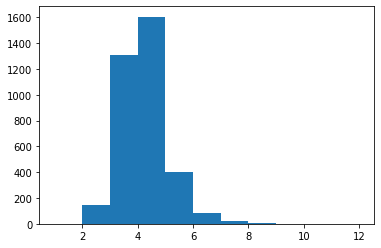

In [16]:
with open(f'../entropies/{corpus_name}/game_entropies.pickle', 'wb+') as f:
    pickle.dump(entropies, f) 
plt.hist(num_tries.values(), bins=range(1, 13))

In [ ]:
# check_p_sums defined in archive
word_p_sums, more_than_one, less_than_one, normal_with_repeating, abormal_uniques = check_p_sums()
more_than_one, less_than_one

## Archive

In [ ]:
# investigate hypotheses for probabilities not adding up to one (abnormal)
# all_abnormals_have_repeating_letters,  all_normals_have_unique_letters
# no normal_with_repeating, no abormal_uniques
def check_p_sums(corpus=five_letter_words, outcomes=None, tol=(1 - 0.9999999999999)):
    if not outcomes:
        outcomes =  all_outcomes((0, 1, 2), 5)
    word_p_sums = {}
    all_abnormals_have_repeating_letters = True
    all_normals_have_unique_letters = True
    more_than_one, less_than_one, normal_with_repeating, abormal_uniques = [], [], [], []
    for i, w in enumerate(corpus):
        print(i, w)
        p_sum = 0
        init_copus_len = len(corpus)
        corpus_set = set(corpus)
        for outcome in outcomes:
            possibilities = get_possibilities(w, outcome, corpus_set)
            if possibilities:
                p_sum += len(possibilities) / init_copus_len
                corpus_set.difference_update(possibilities)
        word_p_sums[w] = p_sum
        if not (1 - tol <= p_sum <= 1 + tol): # abnormal
            if len(set(w)) == 5: # unique
                all_abnormals_have_repeating_letters = False
                abormal_uniques += [w]
            if p_sum < 1 - tol:
                less_than_one += [w]
            elif 1 + tol < p_sum:
                more_than_one += [w]
        elif len(set(w)) < 5: # normal, with repeating letters
                all_normals_have_unique_letters = False
                normal_with_repeating += [w]
#     print('all_abnormals_have_repeating_letters', all_abnormals_have_repeating_letters)
#     print('all_normals_have_unique_letters', all_normals_have_unique_letters)
    return word_p_sums, more_than_one, less_than_one, normal_with_repeating, abormal_uniques

# word_p_sums, more_than_one, less_than_one, normal_with_repeating, abormal_uniques = check_p_sums()

In [ ]:
# The probs deviation from 1 increases as the number of repeating letters increases
from collections import defaultdict
import numpy as np
tol = 1 - 0.9999999999999
num_repeats_to_p_sum = defaultdict(list)
for w, p_sum in word_p_sums.items():
    num_uniques = len(set(w))
    if num_uniques < 5:
        num_repeats_to_p_sum[5 - num_uniques + 1] += [p_sum]
{num_repeats: sum(sums)/len(sums) for num_repeats, sums in num_repeats_to_p_sum.items()}, \
{num_repeats: np.std(sums) for num_repeats, sums in num_repeats_to_p_sum.items()}

In [ ]:
from collections import defaultdict

def check_repeating_outcome_possibilities(word, corpus=five_letter_words, outcomes=None):
    if not outcomes:
        outcomes =  all_outcomes((0, 1, 2), 5)
    unique_possibility_sets = defaultdict(list)
    num_possibility_sets = 0
    for outcome in outcomes:
        possibilities = tuple(sorted(get_possibilities(word, outcome, corpus)))
        if possibilities:
            unique_possibility_sets[possibilities] += [outcome]
            num_possibility_sets += 1
    return unique_possibility_sets, num_possibility_sets

def check_repeating_outcome_p_sums(unique_possibility_sets):
    sum_repeating_ps = 0
    sum_unique_ps = 0
    sum_all_ps = 0
    for possibilities, outcomes in unique_possibility_sets.items():
        p = len(possibilities) / len(five_letter_words)
        if len(outcomes) > 1:
#             print('more than 1:', len(outcomes))
            sum_repeating_ps += (len(outcomes) - 1) * p
            sum_unique_ps += p
        else:
            sum_unique_ps += p
        sum_all_ps += p
    return sum_repeating_ps, sum_unique_ps, sum_all_ps

def check_words_belonging_to_many_outcomes(unique_possibility_sets, corpus=five_letter_words):
    words_to_outcomes = defaultdict(list)
    for w in corpus:
        for possibilities, outcomes in unique_possibility_sets.items():
            if w in possibilities:
                words_to_outcomes[w].extend(outcomes)
        
    return words_to_outcomes
        


In [ ]:
word_to_p_diff = {}
for w in ['reese', 'eerie', 'terre', 'allen', 'isaac']:
    print('\n', w)
    repeating_outcomes, num_possibility_sets = check_repeating_outcome_possibilities(w)
    print('repeating_outcomes, num_possibility_sets', len(repeating_outcomes), num_possibility_sets)
    sum_repeating_ps, sum_unique_ps, sum_all_ps = check_repeating_outcome_p_sums(repeating_outcomes)
    print('sum_repeating_ps, sum_unique_ps, sum_all_ps', sum_repeating_ps, sum_unique_ps, sum_all_ps)

    words_to_outcomes = check_words_belonging_to_many_outcomes(repeating_outcomes)
    p_by_words_with_more_than_one_pattern = sum([len(words_to_outcomes[w]) - 1 for w in words_to_outcomes if len(words_to_outcomes[w]) > 1]) / len(five_letter_words)
    hopefully_one = sum_all_ps - p_by_words_with_more_than_one_pattern
    print('all ps - those from words with more than 1 outcome', hopefully_one)
    word_to_p_diff[w] = hopefully_one
word_to_p_diff

In [ ]:

# def parse_outcome(guess, outcome):
#     correct, present, present_positions, not_present = [], Counter(), [], set()
#     for letter, letter_outcome in zip(guess, outcome):
#         if letter_outcome == 0:
#             not_present.add(letter)
#             correct += [None]
#             present_positions += [None]
#         elif letter_outcome == 1:
#             present[letter] += 1
# #             present[letter] -= 1
#             present_positions += [letter]
#             correct += [None]
#             not_present.discard(letter)
#         elif letter_outcome == 2:
#             correct += letter
#             present_positions += [None]
#             not_present.discard(letter)
#     return correct, present, present_positions, not_present


In [ ]:
letter_outcomes = (0, 1, 2)
'Num possible outcomes', len(all_outcomes(letter_outcomes, 5)) 

In [ ]:
guess =  'abcde' # 'excbx'
outcome = [0,1,2,0,1] # [2,1,2,1,2]
correct, present, present_positions, not_present = parse_outcome(guess, outcome)

corpus = ['abcde', 'eycby', 'excbx', 'excbd', 'excxx', 'ebcxx', 'eycyy']
possibilities = get_init_possibilities(corpus, correct, present_positions)

In [ ]:
# remaining_letters = possibilities['excbx']
for p in possibilities:
    remaining_letters = possibilities[p]
    print(p)
    print(word_matches_present(remaining_letters, present))
    print(word_matches_not_present(remaining_letters, not_present))

In [ ]:
for guess, outcome in zip(['abcde', 'excbx'], [[0,1,2,0,1], [2,1,2,1,2]]):
    print(guess)
    outcome_probabilities = []
    possibilities = get_possibilities(guess, outcome, corpus)
    if possibilities:
        outcome_probability = len(possibilities) / len(corpus)
        outcome_probabilities += [outcome_probability]
        print(outcome, possibilities, outcome_probability)
    print(calc_entropy(outcome_probabilities))

In [ ]:
2/7

In [ ]:
get_entropy('excbx', corpus, all_outcomes((0, 1, 2), 5))

In [ ]:
ps = [1 / len(corpus)] * 4 + [2 / len(corpus)]
-sum([p * math.log(p, 2) for p in ps])

In [ ]:
(calc_info_gain(len(corpus), 1)*4 + calc_info_gain(len(corpus), 2))/5

In [ ]:
calc_info_gain(5757, 12)

In [ ]:
# test_outcomes = ((0,0,0,0,0), (2,2,2,2,2), (0,0,2,0,0))
get_best_guess(corpus)

In [ ]:
get_entropy('eycyy', corpus, test_outcomes)

In [ ]:
best_guess = max(init_entropies, key=init_entropies.get)

In [ ]:
[(w, init_entropies[w]) for w in reversed(sorted(init_entropies, key=init_entropies.get))]

In [ ]:
init_entropies['fuzzy']